In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from typing import List, Tuple, Literal

import warnings
warnings.filterwarnings('ignore')
SKLEARN_AVAILABLE = True

In [2]:
def gaussian_kernel(distances: np.ndarray, bandwidth: float) -> np.ndarray:
    """
    Gaussian kernel function.
    
    Parameters:
    -----------
    distances : np.ndarray
        Array of distances from kernel center
    bandwidth : float
        Kernel bandwidth parameter
        
    Returns:
    --------
    np.ndarray
        Kernel weights (unnormalized)
    """
    return np.exp(-0.5 * (distances / bandwidth) ** 2)

def epanechnikov_kernel(distances: np.ndarray, bandwidth: float) -> np.ndarray:
    """
    Epanechnikov kernel function (compact support).
    
    Parameters:
    -----------
    distances : np.ndarray
        Array of distances from kernel center
    bandwidth : float
        Kernel bandwidth parameter
        
    Returns:
    --------
    np.ndarray
        Kernel weights (unnormalized)
    """
    u = distances / bandwidth
    return np.maximum(0, 0.75 * (1 - u**2))

def compute_kernel_weights(x_data: np.ndarray, 
                        center: float, 
                        bandwidth: float,
                        kernel: Literal['gaussian', 'epanechnikov'] = 'gaussian') -> np.ndarray:
    """
    Compute normalized kernel weights for data points relative to a center point.
    
    Parameters:
    -----------
    x_data : np.ndarray
        Input data points (x-coordinates)
    center : float
        Center point for kernel weighting
    bandwidth : float
        Kernel bandwidth parameter
    kernel : str
        Kernel type ('gaussian' or 'epanechnikov')
        
    Returns:
    --------
    np.ndarray
        Normalized weights summing to 1
    """
    distances = np.abs(x_data - center)
    
    if kernel == 'gaussian':
        weights = gaussian_kernel(distances, bandwidth)
    elif kernel == 'epanechnikov':
        weights = epanechnikov_kernel(distances, bandwidth)
    else:
        raise ValueError(f"Unknown kernel: {kernel}")
    
    # Normalize weights to sum to 1
    total_weight = np.sum(weights)
    if total_weight > 0:
        weights = weights / total_weight
    else:
        # Fallback: equal weights if all weights are zero
        weights = np.ones_like(weights) / len(weights)
    
    return weights

def estimate_knot_values(x_data: np.ndarray, 
                        y_data: np.ndarray,
                        knots: List[float],
                        bandwidth: float,
                        kernel: Literal['gaussian', 'epanechnikov'] = 'gaussian') -> np.ndarray:
    """
    Estimate function values at specified knot points using kernel-weighted averaging.
    
    Parameters:
    -----------
    x_data : np.ndarray
        Input data points (x-coordinates)
    y_data : np.ndarray
        Output data points (y-coordinates)
    knots : List[float]
        Knot positions where to estimate function values
    bandwidth : float
        Kernel bandwidth parameter
    kernel : str
        Kernel type ('gaussian' or 'epanechnikov')
        
    Returns:
    --------
    np.ndarray
        Estimated function values at knot positions
    """
    knot_values = []
    
    for knot in knots:
        # Compute kernel weights for this knot
        weights = compute_kernel_weights(x_data, knot, bandwidth, kernel)
        
        # Weighted average of y-values
        knot_value = np.sum(weights * y_data)
        knot_values.append(knot_value)
    
    return np.array(knot_values)

def auto_bandwidth_selection(x_data: np.ndarray, method: str = 'silverman') -> float:
    """
    Automatic bandwidth selection using common rules of thumb.
    
    Parameters:
    -----------
    x_data : np.ndarray
        Input data points
    method : str
        Bandwidth selection method ('silverman', 'scott', or 'iqr')
        
    Returns:
    --------
    float
        Estimated optimal bandwidth
    """
    n = len(x_data)
    
    if method == 'silverman':
        # Silverman's rule of thumb
        std_x = np.std(x_data)
        iqr_x = np.percentile(x_data, 75) - np.percentile(x_data, 25)
        h = 0.9 * min(std_x, iqr_x / 1.34) * (n ** (-1/5))
    
    elif method == 'scott':
        # Scott's rule
        std_x = np.std(x_data)
        h = std_x * (n ** (-1/5))
    
    elif method == 'iqr':
        # Simple IQR-based rule
        iqr_x = np.percentile(x_data, 75) - np.percentile(x_data, 25)
        h = 0.5 * iqr_x
    
    else:
        raise ValueError(f"Unknown bandwidth selection method: {method}")
    
    return h

def create_data_envelope(x_data, y_data, x_smooth, y_smooth, window_size=0.2):
    """
    Create confidence envelope based on local min/max of actual data points.
    """
    y_upper = np.zeros_like(x_smooth)
    y_lower = np.zeros_like(x_smooth)
    
    for i, x_point in enumerate(x_smooth):
        # Find data points within window around this x_point
        distances = np.abs(x_data - x_point)
        mask = distances <= window_size
        
        if np.sum(mask) > 0:
            local_y = y_data[mask]
            
            # Local max and min
            local_max = np.max(local_y)
            local_min = np.min(local_y)
            
            # Ensure envelope contains the trend line
            y_upper[i] = max(local_max, y_smooth[i])
            y_lower[i] = min(local_min, y_smooth[i])
        else:
            # Fallback: no nearby points
            y_upper[i] = y_smooth[i] + 0.05
            y_lower[i] = y_smooth[i] - 0.05
    
    return y_upper, y_lower

def create_direct_envelope(x_data, y_data, x_smooth, y_smooth, window_size=0.2, manual_slope_factor=0.0):
    """
    Create envelope by taking local max/min at observed data points,
    then piecewise linear connecting them.
    """
    # Interpolate the trend line at data point locations
    trend_at_data = np.interp(x_data, x_smooth, y_smooth)
    
    # Find points above and below the trend line
    above_mask = y_data > trend_at_data
    below_mask = y_data < trend_at_data
    
    # Get points above and below the line
    x_above = x_data[above_mask]
    y_above = y_data[above_mask]
    x_below = x_data[below_mask]
    y_below = y_data[below_mask]
    
    # Create upper envelope points
    if len(x_above) > 0:
        y_max_values = []
        x_envelope_upper = []
        
        for i, x_point in enumerate(x_above):
            # Find all "above" points within window of this observed point
            distances = np.abs(x_above - x_point)
            local_mask = distances <= window_size
            
            # Take max of nearby points
            local_y_above = y_above[local_mask]
            y_max_i = np.max(local_y_above)
            
            y_max_values.append(y_max_i)
            x_envelope_upper.append(x_point)
        
        # Sort by x for proper piecewise linear connection
        sort_idx = np.argsort(x_envelope_upper)
        x_envelope_upper = np.array(x_envelope_upper)[sort_idx]
        y_max_values = np.array(y_max_values)[sort_idx]
        
        # Interpolate to x_smooth points
        y_upper = np.interp(x_smooth, x_envelope_upper, y_max_values)
        y_upper = np.maximum(y_upper, y_smooth)
        
        y_upper = np.interp(x_smooth, x_envelope_upper, y_max_values)
        y_upper = np.maximum(y_upper, y_smooth)
        
        # Add manual slope for left extrapolation only
        data_min_x = np.min(x_envelope_upper)  # Leftmost actual data point
        extrap_mask = x_smooth < data_min_x
        
        if np.any(extrap_mask) and manual_slope_factor != 0.0:
            boundary_idx = np.argmin(np.abs(x_smooth - data_min_x))
            boundary_y = y_upper[boundary_idx]
            dx = data_min_x - x_smooth[extrap_mask]
            y_upper[extrap_mask] = boundary_y + manual_slope_factor * 0.1 * dx


    else:
        y_upper = y_smooth + 0.02
    
    # Create lower envelope points  
    if len(x_below) > 0:
        y_min_values = []
        x_envelope_lower = []
        
        for i, x_point in enumerate(x_below):
            # Find all "below" points within window of this observed point
            distances = np.abs(x_below - x_point)
            local_mask = distances <= window_size
            
            # Take min of nearby points
            local_y_below = y_below[local_mask]
            y_min_i = np.min(local_y_below)
            
            y_min_values.append(y_min_i)
            x_envelope_lower.append(x_point)
        
        # Sort by x for proper piecewise linear connection
        sort_idx = np.argsort(x_envelope_lower)
        x_envelope_lower = np.array(x_envelope_lower)[sort_idx]
        y_min_values = np.array(y_min_values)[sort_idx]
        
        # Interpolate to x_smooth points
        y_lower = np.interp(x_smooth, x_envelope_lower, y_min_values)
        y_lower = np.minimum(y_lower, y_smooth)
    else:
        y_lower = y_smooth - 0.02
    
    return y_upper, y_lower

def create_direct_envelope2(x_data, y_data, x_smooth, y_smooth, window_size=0.2):
    """
    Create envelope by connecting actual data points above/below the trend line,
    with local smoothing to avoid zig-zag effects.
    """
    # Interpolate the trend line at data point locations
    trend_at_data = np.interp(x_data, x_smooth, y_smooth)
    
    # Find points above and below the trend line
    above_mask = y_data > trend_at_data
    below_mask = y_data < trend_at_data
    
    # Get points above and below the line
    x_above = x_data[above_mask]
    y_above = y_data[above_mask]
    x_below = x_data[below_mask]
    y_below = y_data[below_mask]
    
    # Create upper envelope with local smoothing
    if len(x_above) > 0:
        y_upper = np.zeros_like(x_smooth)
        
        for i, x_point in enumerate(x_smooth):
            # Find all "above" points within the local window
            distances = np.abs(x_above - x_point)
            local_mask = distances <= window_size
            
            if np.sum(local_mask) > 0:
                # Take the maximum y-value among nearby "above" points
                local_y_above = y_above[local_mask]
                y_upper[i] = np.max(local_y_above)
            else:
                # No nearby "above" points, use trend line + small buffer
                y_upper[i] = y_smooth[i] + 0.02
        
        # Ensure upper envelope is always >= trend line
        y_upper = np.maximum(y_upper, y_smooth)
    else:
        # No points above trend line
        y_upper = y_smooth + 0.02
    
    # Create lower envelope with local smoothing
    if len(x_below) > 0:
        y_lower = np.zeros_like(x_smooth)
        
        for i, x_point in enumerate(x_smooth):
            # Find all "below" points within the local window
            distances = np.abs(x_below - x_point)
            local_mask = distances <= window_size
            
            if np.sum(local_mask) > 0:
                # Take the minimum y-value among nearby "below" points
                local_y_below = y_below[local_mask]
                y_lower[i] = np.min(local_y_below)
            else:
                # No nearby "below" points, use trend line - small buffer
                y_lower[i] = y_smooth[i] - 0.02
        
        # Ensure lower envelope is always <= trend line
        y_lower = np.minimum(y_lower, y_smooth)
    else:
        # No points below trend line
        y_lower = y_smooth - 0.02
    
    return y_upper, y_lower

def create_binned_envelope(x_data, y_data, x_smooth, y_smooth, n_bins=15):
    """
    Divide x-range into bins, find min/max in each bin, then interpolate.
    """
    # Create bins
    x_min, x_max = x_data.min(), x_data.max()
    bin_edges = np.linspace(x_min, x_max, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    bin_maxes = []
    bin_mins = []
    
    for i in range(n_bins):
        mask = (x_data >= bin_edges[i]) & (x_data < bin_edges[i+1])
        if np.sum(mask) > 0:
            bin_maxes.append(np.max(y_data[mask]))
            bin_mins.append(np.min(y_data[mask]))
        else:
            # No data in this bin
            bin_maxes.append(np.nan)
            bin_mins.append(np.nan)
    
    # Interpolate to smooth curve
    valid_bins = ~np.isnan(bin_maxes)
    if np.sum(valid_bins) > 1:
        y_upper = np.interp(x_smooth, bin_centers[valid_bins], np.array(bin_maxes)[valid_bins])
        y_lower = np.interp(x_smooth, bin_centers[valid_bins], np.array(bin_mins)[valid_bins])
    else:
        # Fallback if not enough valid bins
        y_upper = y_smooth + 0.05
        y_lower = y_smooth - 0.05
    
    # Ensure envelope contains trend line
    y_upper = np.maximum(y_upper, y_smooth)
    y_lower = np.minimum(y_lower, y_smooth)
    
    return y_upper, y_lower

def piecewise_linear_interpolation(knots: np.ndarray, 
                                knot_values: np.ndarray,
                                x_smooth: np.ndarray) -> np.ndarray:
    """
    Create piecewise linear interpolation through knot points.
    
    Parameters:
    -----------
    knots : np.ndarray
        Knot x-coordinates (must be sorted)
    knot_values : np.ndarray
        Function values at knots
    x_smooth : np.ndarray
        Points where to evaluate the piecewise function
        
    Returns:
    --------
    np.ndarray
        Interpolated y-values at x_smooth points
    """
    # Use numpy's interp for simple linear interpolation
    # Extrapolate using the nearest segment slope for points outside knot range
    return np.interp(x_smooth, knots, knot_values)

def kernel_piecewise_regression(x_data: np.ndarray,
                                y_data: np.ndarray, 
                                breakpoints: List[float],
                                x_smooth: np.ndarray,
                                bandwidth: float = None,
                                kernel: Literal['gaussian', 'epanechnikov'] = 'gaussian',
                                auto_bandwidth_method: str = 'silverman') -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Main function: Kernel-weighted piecewise regression.
    
    Estimates function values at specified breakpoints using kernel-weighted 
    averaging, then connects them with piecewise linear segments.
    
    Parameters:
    -----------
    x_data : np.ndarray
        Input data points (x-coordinates)
    y_data : np.ndarray
        Output data points (y-coordinates)  
    breakpoints : List[float]
        Knot positions (breakpoints) - will be sorted automatically
    x_smooth : np.ndarray
        Points where to evaluate the smooth function
    bandwidth : float, optional
        Kernel bandwidth. If None, uses automatic selection
    kernel : str
        Kernel type ('gaussian' or 'epanechnikov')
    auto_bandwidth_method : str
        Method for automatic bandwidth selection if bandwidth=None
        
    Returns:
    --------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        (knots, knot_values, y_smooth) where:
        - knots: sorted breakpoint positions
        - knot_values: estimated function values at knots
        - y_smooth: piecewise linear interpolation at x_smooth points
    """
    
    # Sort breakpoints
    knots = np.array(sorted(breakpoints))
    
    # Auto-select bandwidth if not provided
    if bandwidth is None:
        bandwidth = auto_bandwidth_selection(x_data, auto_bandwidth_method)
        print(f"Auto-selected bandwidth: {bandwidth:.3f}")
    
    # Estimate function values at knots using kernel weighting
    knot_values = estimate_knot_values(x_data, y_data, knots, bandwidth, kernel)
    
    # Create piecewise linear interpolation
    y_smooth = piecewise_linear_interpolation(knots, knot_values, x_smooth)
    
    return knots, knot_values, y_smooth


In [3]:
def plot_nba_performance(data_file, output_file=None, figsize=(12, 8), dpi=300, 
                        trend_type='kernel_piecewise', breakpoints=None, 
                        envelope_type='direct', window_size=0.05, n_bins=15,
                        flip_axis=False, x_min_billions=1.0, x_max_billions=1200.0,
                        plot_label='Genomics Question Answering Across Model Sizes', legend_loc='lower right'):
    """
    Create a publication-ready plot showing NBA performance across model sizes.
    
    Parameters:
    -----------
    data_file : str
        Path to CSV file with columns: model, num_parameters, score
    output_file : str, optional
        Path for saving the output plot (e.g., 'nba_performance.png').
        If None, replaces input file extension with .png
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for saved figure
    trend_type : str
        Type of trend line: 'exponential', 'piecewise', 'moving_average', 'kernel_piecewise', or 'linear'
    breakpoints : list of float, optional
        List of log10(parameter) values for piecewise breakpoints. 
        Default: [10.5] (30B parameters). Example: [11.0, 10.0, 9.5] for breaks at 100B, 10B, 3B
    envelope_type : str
        Type of confidence envelope: 'fixed', 'data', 'binned', or 'direct'
    window_size : float
        Window size for 'data' and 'direct' envelope types (in x-axis units)
    n_bins : int
        Number of bins for 'binned' envelope type
    flip_axis : bool
        If True, flip x-axis so right side shows smaller models (downsizing)
    x_min_billions : float
        Minimum x-axis value in billions of parameters (default: 1.0 = 1B)
    x_max_billions : float
        Maximum x-axis value in billions of parameters (default: 1500.0 = 1.5T)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Read data
    df = pd.read_csv(data_file)
    
    # Auto-generate output filename if not provided
    if output_file is None:
        import os
        base_name = os.path.splitext(data_file)[0]  # Remove .csv extension
        output_file = f"{base_name}.png"
        
    # Convert to billions and take log
    df['num_parameters_billions'] = df['num_parameters'] / 1e9
    df['log_num_parameters_billions'] = np.log10(df['num_parameters_billions'])

    # Flip axis if requested
    if flip_axis:
        # Flip so smaller models (lower params) are on the right
        df['x_plot'] = -df['log_num_parameters_billions']
        x_label = 'Log₁₀(Billions of Parameters) [Flipped: Smaller Models →]'
    else:
        df['x_plot'] = df['log_num_parameters_billions'] 
        x_label = 'Log₁₀(Billions of Total Parameters)'
    
    # Sort by plot coordinate for smooth curve
    df_sorted = df.sort_values('x_plot')
        
    # Set up the plot with publication style
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Rainbow color scheme for 6 parameter ranges
    def get_model_color(log_params_billions, flipped=False):
        """
        Rainbow color scheme for 6 parameter ranges:
        0-3B: Red, 3-10B: Orange, 10-32B: Yellow, 32-100B: Green, 100-320B: Blue, 320B+: Purple
        """
        # Convert back to absolute value for color determination
        abs_log_params = abs(log_params_billions) if flipped else log_params_billions
        
        if abs_log_params < 0.5:  # 0-3B parameters (log10(3) ≈ 0.48)
            return '#FF0000'  # Red
        elif abs_log_params < 1.0:  # 3-10B parameters (log10(10) = 1.0)
            return '#FF8C00'  # Dark Orange
        elif abs_log_params < 1.5:  # 10-32B parameters (log10(32) ≈ 1.51)
            return '#FFD700'  # Gold/Dark Yellow
        elif abs_log_params < 2.0:  # 32-100B parameters (log10(100) = 2.0)
            return '#32CD32'  # Lime Green
        # elif abs_log_params < 2.5:  # 100-320B parameters (log10(320) ≈ 2.51)
        elif abs_log_params < 2.7:  # 100-500B parameters (log10(500) ≈ 2.7)
            return '#1E90FF'  # Dodger Blue
        else:  # 320B+ parameters
            return '#8A2BE2'  # Blue Violet/Purple
    
    # Create color array
    colors = [get_model_color(x, flip_axis) for x in df['x_plot']]
    
    # Plot individual points
    scatter = ax.scatter(df['x_plot'], df['score'], 
                        c=colors, alpha=0.7, s=60, edgecolors='white', linewidth=0.5,
                        zorder=5)
    
    # Create smooth trend line based on trend_type
    x_smooth = np.linspace(df['x_plot'].min(), df['x_plot'].max(), 300)
    x_data = df_sorted['x_plot'].values
    y_data = df_sorted['score'].values
    
    if trend_type == 'exponential':
        # Exponential saturation model: high performance plateau, then decline
        # Model: y = a * (1 - exp(-b * (x - x_min))) + c
        x_norm = (x_smooth - x_smooth.min()) / (x_smooth.max() - x_smooth.min())
        
        # Parameters tuned for genomics performance pattern
        plateau_score = 0.95  # High performance for large models
        min_score = 0.2       # Low performance for very small models
        steepness = 3.0       # Controls how quickly performance drops
        
        y_smooth = min_score + (plateau_score - min_score) * (1 - np.exp(-steepness * x_norm))
    
    elif trend_type == 'kernel_piecewise':
        
        knots, knot_values, y_smooth = kernel_piecewise_regression(
            x_data, y_data, breakpoints, x_smooth, 
            bandwidth=0.1,  # or None for auto
            kernel='gaussian'
        )
        '''
        knots, knot_values, _ = kernel_piecewise_regression(
            x_data, y_data, breakpoints, x_smooth, 
            bandwidth=0.2,  # or None for auto
            kernel='gaussian'
        )
        
        # Use cubic spline interpolation for smooth curves
        from scipy.interpolate import CubicSpline
        cs = CubicSpline(knots, knot_values)
        y_smooth = cs(x_smooth)
        
        from scipy.interpolate import make_interp_spline
        spline = make_interp_spline(knots, knot_values, k=1)  # k=3 for cubic B-splines
        y_smooth = spline(x_smooth)
        '''
        
    
    elif trend_type == 'piecewise':
        # Multi-segment piecewise linear with configurable breakpoints
        if breakpoints is None:
            breakpoints = [1.5]  # Default: single break at ~32B parameters (log10(32) ≈ 1.5)
        
        # Sort breakpoints in descending order (high to low params)
        breakpoints = sorted(breakpoints, reverse=True)
        
        # Create segments based on breakpoints
        segments = []
        x_ranges = []
        
        # Define parameter ranges for each segment
        prev_break = float('inf')
        for bp in breakpoints:
            x_ranges.append((bp, prev_break))
            prev_break = bp
        x_ranges.append((float('-inf'), prev_break))  # Final segment
        
        # Fit linear regression for each segment
        segment_slopes = []
        segment_intercepts = []
        
        for i, (x_min, x_max) in enumerate(x_ranges):
            if x_max == float('inf'):
                mask = x_data >= x_min
            elif x_min == float('-inf'):
                mask = x_data < x_max
            else:
                mask = (x_data >= x_min) & (x_data < x_max)
            
            if np.sum(mask) > 1:
                # Fit linear trend for this segment
                slope, intercept = np.polyfit(x_data[mask], y_data[mask], 1)
            elif np.sum(mask) == 1:
                # Single point: use flat line
                slope = 0
                intercept = y_data[mask][0]
            else:
                # No points: use reasonable defaults
                if i == 0:  # Highest parameter segment
                    slope = 0
                    intercept = 0.95
                else:  # Lower parameter segments
                    slope = 0.2
                    intercept = -1.5
            
            segment_slopes.append(slope)
            segment_intercepts.append(intercept)
        
        # Create piecewise function
        y_smooth = np.zeros_like(x_smooth)
        
        for i, x_val in enumerate(x_smooth):
            # Determine which segment this x_val belongs to
            segment_idx = len(breakpoints)  # Default to last segment
            for j, bp in enumerate(breakpoints):
                if x_val >= bp:
                    segment_idx = j
                    break
            
            # Calculate y value using segment's linear function
            y_smooth[i] = segment_slopes[segment_idx] * x_val + segment_intercepts[segment_idx]
        
        # Ensure continuity at breakpoints by adjusting intercepts
        for i, bp in enumerate(breakpoints):
            if i > 0:  # Not the first segment
                # Value from left segment at breakpoint
                left_val = segment_slopes[i-1] * bp + segment_intercepts[i-1]
                # Value from right segment at breakpoint  
                right_val = segment_slopes[i] * bp + segment_intercepts[i]
                
                # Adjust right segment to match left
                adjustment = left_val - right_val
                segment_intercepts[i] += adjustment
                
                # Update y_smooth for affected points
                mask = x_smooth >= bp
                y_smooth[mask] = segment_slopes[i] * x_smooth[mask] + segment_intercepts[i]
    
    elif trend_type == 'moving_average':
        # Smoothed interpolation through actual data points
        # First, aggregate duplicates by taking mean scores for same parameter counts
        df_agg = df_sorted.groupby('x_plot')['score'].mean().reset_index()
        x_data_unique = df_agg['x_plot'].values
        y_data_unique = df_agg['score'].values
        
        try:
            from scipy.interpolate import interp1d
            # Create interpolation function with deduplicated data
            f = interp1d(x_data_unique, y_data_unique, kind='cubic', fill_value='extrapolate')
            y_smooth_raw = f(x_smooth)
            
            # Apply moving average smoothing
            window = max(5, len(y_smooth_raw) // 15)
            kernel = np.ones(window) / window
            y_smooth = np.convolve(y_smooth_raw, kernel, mode='same')
        except ImportError:
            # Fallback: simple linear interpolation
            y_smooth = np.interp(x_smooth, x_data_unique, y_data_unique)
    
    elif trend_type == 'linear':
        # Simple linear fit
        slope, intercept = np.polyfit(x_data, y_data, 1)
        y_smooth = slope * x_smooth + intercept
    
    else:
        raise ValueError(f"Unknown trend_type: {trend_type}. Use 'exponential', 'piecewise', 'moving_average', 'kernel_piecewise', or 'linear'")
    
    # Ensure y_smooth stays within reasonable bounds
    y_smooth = np.clip(y_smooth, 0, 1)
    
    # Create confidence envelope based on envelope_type
    if envelope_type == 'fixed':
        # Original fixed-width approach
        confidence_std = 0.04
        y_upper = np.clip(y_smooth + confidence_std, 0, 1)
        y_lower = np.clip(y_smooth - confidence_std, 0, 1)
    elif envelope_type == 'data':
        # Data-driven envelope using sliding window
        y_upper, y_lower = create_data_envelope(x_data, y_data, x_smooth, y_smooth, window_size)
        y_upper = np.clip(y_upper, 0, 1)
        y_lower = np.clip(y_lower, 0, 1)
    elif envelope_type == 'binned':
        # Data-driven envelope using binned approach
        y_upper, y_lower = create_binned_envelope(x_data, y_data, x_smooth, y_smooth, n_bins)
        y_upper = np.clip(y_upper, 0, 1)
        y_lower = np.clip(y_lower, 0, 1)
    elif envelope_type == 'direct':
        # Direct envelope: connect actual points above/below trend line with local smoothing
        y_upper, y_lower = create_direct_envelope(x_data, y_data, x_smooth, y_smooth, window_size, manual_slope_factor=-6.0)
        y_upper = np.clip(y_upper, 0, 1)
        y_lower = np.clip(y_lower, 0, 1)
    else:
        raise ValueError(f"Unknown envelope_type: {envelope_type}. Use 'fixed', 'data', 'binned', or 'direct'")
    
    # Plot trend line and confidence band
    # ax.plot(x_smooth, y_smooth, color='#2E4057', linewidth=3, zorder=4, 
    #        label=f'Performance Trend ({trend_type})')
    # Plot trend line and confidence band
    ax.plot(x_smooth, y_smooth, color='darkblue', linewidth=3, linestyle='--', zorder=4, 
            label=f'Performance Trend ({trend_type})')
    # Light blue envelope
    color_fill = 'lightblue'
    ax.fill_between(x_smooth, y_lower, y_upper, alpha=0.3, color=color_fill, 
                    zorder=3, label=f'{envelope_type.title()} Envelope')
    
    # Customize the plot
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy Score (GeneTuring)', fontsize=10, fontweight='bold')
    if not plot_label == '':
        ax.set_title(plot_label, fontsize=16, fontweight='bold', pad=20)
    
    # Set fixed axis limits based on billions
    x_min_log = np.log10(x_min_billions)
    x_max_log = np.log10(x_max_billions)

    if flip_axis:
        ax.set_xlim(-x_max_log, -x_min_log)  # Flipped: -3.18 to 0 (1.5T to 1B)
    else:
        ax.set_xlim(x_min_log, x_max_log)    # Normal: 0 to 3.18 (1B to 1.5T)
    
    ax.set_ylim(0, 1.05)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Create custom legend for model sizes with rainbow colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF0000', label='Tiny Models (0-3B params)'),
        Patch(facecolor='#FF8C00', label='Small Models (3-10B params)'),
        Patch(facecolor='#FFD700', label='Medium Models (10-32B params)'),
        Patch(facecolor='#32CD32', label='Large Models (32-100B params)'),
        # Patch(facecolor='#1E90FF', label='Very Large Models (100-320B params)'),
        Patch(facecolor='#1E90FF', label='Very Large Models (100-500B params)'),
        Patch(facecolor='#8A2BE2', label='Frontier LLM Models (Size Unknown)')
    ]
    
    # Add trend line to legend
    legend_elements.append(plt.Line2D([0], [0], color='#2E4057', linewidth=3, alpha=0.5, label=f'Trend'))

    # Other options: 'upper right', 'upper center', 'lower left', 'lower center', 'center left', 'center right', 'center'
    ax.legend(handles=legend_elements, loc=legend_loc, fontsize=10)
    
    # Add parameter size annotations on top x-axis
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    
    # Create tick positions and labels
    if flip_axis:
        # Flipped: 0, -1, -2, -3 corresponding to 1B, 10B, 100B, 1T
        param_ticks = [0, -1, -2, -3]
        param_labels = ['1B', '10B', '100B', 'Unknown']
        ax2.set_xlabel('Model Size (#Total Parameters) [Smaller Models →]', fontsize=12, fontweight='bold')
    else:
        # Normal: 0, 1, 2, 3 corresponding to 1B, 10B, 100B, 1T  
        param_ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3]
        param_labels = ['1B', '3B', '10B', '32B', '100B', '320B', 'Unknown']
        ax2.set_xlabel('Model Size (#Total Parameters)', fontsize=12, fontweight='bold')

    ax2.set_xticks(param_ticks)
    ax2.set_xticklabels(param_labels)
    

    # Highlight key insight with annotation
    # Find a good SLM model to highlight
    slm_threshold = 1.5 if not flip_axis else -1.5  # 32B parameters threshold
    slm_models = df[df['x_plot'] < slm_threshold].nlargest(3, 'score')
    if not slm_models.empty:
        best_slm = slm_models.iloc[0]
        model_name = best_slm["model"].split("_")[-1] if "_" in best_slm["model"] else best_slm["model"]
        model_name = model_name[:20] + "..." if len(model_name) > 20 else model_name
        
        offset_x = 0.5 if not flip_axis else -0.5
        '''
        ax.annotate(f'NBA + {model_name}\nScore: {best_slm["score"]:.3f}',
                xy=(best_slm['x_plot'], best_slm['score']),
                xytext=(best_slm['x_plot'] + offset_x, best_slm['score'] + 0.05),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
        '''
    # Add performance threshold lines
    excellent_score = 1.00
    ax.axhline(y=excellent_score, color='green', linestyle=':', alpha=0.6, linewidth=2)
    text_x = ax.get_xlim()[1] - 0.5 if not flip_axis else ax.get_xlim()[0] + 0.5
    ax.text(text_x, excellent_score, f'Perfect ({excellent_score}+)', 
            fontsize=12, color='green', fontweight='bold')

    benchmark_score = 0.83
    ax.axhline(y=benchmark_score, color='orange', linestyle=':', alpha=0.6, linewidth=2)
    ax.text(text_x, benchmark_score, f'High ({benchmark_score}+)', 
            fontsize=12, color='orange', fontweight='bold')

    
    # Improve tick formatting
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='x', which='major', labelsize=11)
    
    
    
    # Add subtle background
    ax.set_facecolor('#fafafa')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_file, dpi=dpi, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # Display the plot
    plt.show()
    
    return fig, ax

In [4]:
def plot_nba_performance_multi(list_data_file, output_file=None, figsize=(12, 8), dpi=300, 
                            trend_type='kernel_piecewise', list_breakpoints=None, 
                            envelope_type='direct', window_size=0.05, n_bins=15,
                            flip_axis=False, x_min_billions=1.0, x_max_billions=1200.0,
                            plot_label='Genomics Question Answering Across Model Sizes', 
                            legend_loc='lower right', list_markers=None, list_labels=None):
    """
    Create a publication-ready plot showing NBA performance across model sizes for multiple datasets.
    
    Parameters:
    -----------
    list_data_file : list of str
        List of paths to CSV files with columns: model, num_parameters, score
    output_file : str, optional
        Path for saving the output plot (e.g., 'nba_performance.png').
        If None, joins input filenames with "$" and adds .png extension
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for saved figure
    trend_type : str
        Type of trend line: 'exponential', 'piecewise', 'moving_average', 'kernel_piecewise', or 'linear'
    list_breakpoints : list of lists, optional
        List of breakpoint lists for each dataset. Each inner list contains log10(parameter) values.
        If None, uses default breakpoints for all datasets.
    envelope_type : str
        Type of confidence envelope: 'fixed', 'data', 'binned', or 'direct'
    window_size : float
        Window size for 'data' and 'direct' envelope types (in x-axis units)
    n_bins : int
        Number of bins for 'binned' envelope type
    flip_axis : bool
        If True, flip x-axis so right side shows smaller models (downsizing)
    x_min_billions : float
        Minimum x-axis value in billions of parameters (default: 1.0 = 1B)
    x_max_billions : float
        Maximum x-axis value in billions of parameters (default: 1500.0 = 1.5T)
    plot_label : str
        Title for the plot
    legend_loc : str
        Location for the legend
    list_markers : list of str, optional
        List of marker styles for each dataset. Default: ['o', 's', '^']
    list_labels : list of str, optional
        List of labels for each dataset. If None, uses filenames
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Input validation
    if not isinstance(list_data_file, list) or len(list_data_file) == 0:
        raise ValueError("list_data_file must be a non-empty list of file paths")
    
    # Auto-generate output filename if not provided
    if output_file is None:
        import os
        base_names = [os.path.splitext(os.path.basename(f))[0] for f in list_data_file]
        output_file = "$".join(base_names) + ".png"
    
    # Set default markers if not provided
    if list_markers is None:
        list_markers = ['o', 's', '^', 'D', 'v', 'p']  # circle, square, triangle, diamond, triangle_down, pentagon
    
    # Ensure we have enough markers
    if len(list_markers) < len(list_data_file):
        # Repeat markers if we don't have enough
        list_markers = (list_markers * ((len(list_data_file) // len(list_markers)) + 1))[:len(list_data_file)]
    
    # Set default breakpoints if not provided
    if list_breakpoints is None:
        default_breakpoints = [1.5]  # Default: single break at ~32B parameters
        list_breakpoints = [default_breakpoints] * len(list_data_file)
    
    # Ensure we have breakpoints for each dataset
    if len(list_breakpoints) != len(list_data_file):
        raise ValueError("list_breakpoints must have the same length as list_data_file")
    
    # Set default labels if not provided
    if list_labels is None:
        import os
        list_labels = [os.path.splitext(os.path.basename(f))[0] for f in list_data_file]
    
    # Read all datasets
    datasets = []
    all_data = pd.DataFrame()
    
    for i, data_file in enumerate(list_data_file):
        df = pd.read_csv(data_file)
        df['dataset_idx'] = i
        df['dataset_label'] = list_labels[i]
        df['marker'] = list_markers[i]
        datasets.append(df)
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    # Convert to billions and take log for all data
    all_data['num_parameters_billions'] = all_data['num_parameters'] / 1e9
    all_data['log_num_parameters_billions'] = np.log10(all_data['num_parameters_billions'])

    # Flip axis if requested
    if flip_axis:
        all_data['x_plot'] = -all_data['log_num_parameters_billions']
        x_label = 'Log₁₀(Billions of Parameters) [Flipped: Smaller Models →]'
    else:
        all_data['x_plot'] = all_data['log_num_parameters_billions'] 
        x_label = 'Log₁₀(Billions of Total Parameters)'
    
    # Set up the plot with publication style
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Rainbow color scheme for 6 parameter ranges
    def get_model_color(log_params_billions, flipped=False):
        """
        Rainbow color scheme for 6 parameter ranges:
        0-3B: Red, 3-10B: Orange, 10-32B: Yellow, 32-100B: Green, 100-500B: Blue, 500B+: Purple
        """
        abs_log_params = abs(log_params_billions) if flipped else log_params_billions
        import math
        if abs_log_params < math.log10(3): # 0-3B parameters
            return '#FF0000'  # Red
        elif abs_log_params < 1.0:  # 3-10B parameters
            return '#FF8C00'  # Dark Orange
        elif abs_log_params < math.log10(32):  # 10-32B parameters
            return '#FFD700'  # Gold/Dark Yellow
        elif abs_log_params < 2.0:  # 32-100B parameters
            return '#32CD32'  # Lime Green
        elif abs_log_params < math.log10(500):  # 100-500B parameters
            return '#1E90FF'  # Dodger Blue
        else:  # 500B+ parameters
            return '#8A2BE2'  # Blue Violet/Purple
    
    # Plot points for each dataset with different markers
    scatter_handles = []
    for i, (data_file, marker, label) in enumerate(zip(list_data_file, list_markers, list_labels)):
        dataset_data = all_data[all_data['dataset_idx'] == i]
        colors = [get_model_color(x, flip_axis) for x in dataset_data['x_plot']]
        
        marker_size = 50 if marker in ['x', '+'] else 40
        marker_linewidth = 2.0 if marker in ['x', '+'] else 0.5
        scatter = ax.scatter(dataset_data['x_plot'], dataset_data['score'], 
                        c=colors, alpha=0.7, s=marker_size, marker=marker, 
                        edgecolors='white', linewidth=marker_linewidth, zorder=5,
                        label=label)
        scatter_handles.append(scatter)
    
    # Create trend lines for each dataset
    trend_colors = ['darkgreen', 'darkorange', 'darkred', 'orange', 'purple', 'brown']
    
    for i, (data_file, breakpoints, label) in enumerate(zip(list_data_file, list_breakpoints, list_labels)):
        dataset_data = all_data[all_data['dataset_idx'] == i].copy()
        dataset_data = dataset_data.sort_values('x_plot')
        
        x_data = dataset_data['x_plot'].values
        y_data = dataset_data['score'].values
        
        if len(x_data) == 0:
            continue
            
        # Create smooth trend line
        x_smooth = np.linspace(x_data.min(), x_data.max(), 300)
        
        if trend_type == 'kernel_piecewise':
            knots, knot_values, y_smooth = kernel_piecewise_regression(
                x_data, y_data, breakpoints, x_smooth, 
                bandwidth=0.1,
                kernel='gaussian'
            )
        elif trend_type == 'linear':
            slope, intercept = np.polyfit(x_data, y_data, 1)
            y_smooth = slope * x_smooth + intercept
        elif trend_type == 'moving_average':
            df_agg = dataset_data.groupby('x_plot')['score'].mean().reset_index()
            x_data_unique = df_agg['x_plot'].values
            y_data_unique = df_agg['score'].values
            
            try:
                from scipy.interpolate import interp1d
                f = interp1d(x_data_unique, y_data_unique, kind='cubic', fill_value='extrapolate')
                y_smooth_raw = f(x_smooth)
                window = max(5, len(y_smooth_raw) // 15)
                kernel = np.ones(window) / window
                y_smooth = np.convolve(y_smooth_raw, kernel, mode='same')
            except ImportError:
                y_smooth = np.interp(x_smooth, x_data_unique, y_data_unique)
        else:
            # Default to linear for unknown types
            slope, intercept = np.polyfit(x_data, y_data, 1)
            y_smooth = slope * x_smooth + intercept
        
        # Ensure y_smooth stays within bounds
        y_smooth = np.clip(y_smooth, 0, 1)
        
        # Plot trend line
        color_idx = i % len(trend_colors)
        ax.plot(x_smooth, y_smooth, color=trend_colors[color_idx], 
                linewidth=2, linestyle='--', alpha=0.8, zorder=4)
    
    # Create separate confidence envelopes for each dataset
    envelope_colors = ['lightgreen', 'yellow', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
    envelope_alphas = [0.4, 0.2, 0.2, 0.3, 0.3, 0.3]  # Slightly different alphas for visibility
    
    for i, (data_file, breakpoints, label) in enumerate(zip(list_data_file, list_breakpoints, list_labels)):
        dataset_data = all_data[all_data['dataset_idx'] == i].copy()
        dataset_data = dataset_data.sort_values('x_plot')
        
        x_data = dataset_data['x_plot'].values
        y_data = dataset_data['score'].values
        
        if len(x_data) == 0:
            continue
            
        # Create smooth x range for this dataset
        x_smooth = np.linspace(x_data.min(), x_data.max(), 300)
        
        # Get the trend line we calculated earlier for this dataset
        if trend_type == 'kernel_piecewise':
            knots, knot_values, y_smooth = kernel_piecewise_regression(
                x_data, y_data, breakpoints, x_smooth, 
                bandwidth=0.1,
                kernel='gaussian'
            )
        elif trend_type == 'linear':
            slope, intercept = np.polyfit(x_data, y_data, 1)
            y_smooth = slope * x_smooth + intercept
        elif trend_type == 'moving_average':
            df_agg = dataset_data.groupby('x_plot')['score'].mean().reset_index()
            x_data_unique = df_agg['x_plot'].values
            y_data_unique = df_agg['score'].values
            
            try:
                from scipy.interpolate import interp1d
                f = interp1d(x_data_unique, y_data_unique, kind='cubic', fill_value='extrapolate')
                y_smooth_raw = f(x_smooth)
                window = max(5, len(y_smooth_raw) // 15)
                kernel = np.ones(window) / window
                y_smooth = np.convolve(y_smooth_raw, kernel, mode='same')
            except ImportError:
                y_smooth = np.interp(x_smooth, x_data_unique, y_data_unique)
        else:
            # Default to linear for unknown types
            slope, intercept = np.polyfit(x_data, y_data, 1)
            y_smooth = slope * x_smooth + intercept
        
        y_smooth = np.clip(y_smooth, 0, 1)
        
        # Create confidence envelope for this dataset
        if envelope_type == 'fixed':
            confidence_std = 0.04
            y_upper = np.clip(y_smooth + confidence_std, 0, 1)
            y_lower = np.clip(y_smooth - confidence_std, 0, 1)
        elif envelope_type == 'direct':
            y_upper, y_lower = create_direct_envelope(
                x_data, y_data, x_smooth, y_smooth, window_size, manual_slope_factor=-10.0)
            y_upper = np.clip(y_upper, 0, 1)
            y_lower = np.clip(y_lower, 0, 1)
        elif envelope_type == 'data':
            y_upper, y_lower = create_data_envelope(x_data, y_data, x_smooth, y_smooth, window_size)
            y_upper = np.clip(y_upper, 0, 1)
            y_lower = np.clip(y_lower, 0, 1)
        elif envelope_type == 'binned':
            y_upper, y_lower = create_binned_envelope(x_data, y_data, x_smooth, y_smooth, n_bins)
            y_upper = np.clip(y_upper, 0, 1)
            y_lower = np.clip(y_lower, 0, 1)
        else:
            # Default to fixed envelope for other types
            confidence_std = 0.04
            y_upper = np.clip(y_smooth + confidence_std, 0, 1)
            y_lower = np.clip(y_smooth - confidence_std, 0, 1)
        
        # Plot confidence envelope for this dataset
        color_idx = i % len(envelope_colors)
        alpha_idx = i % len(envelope_alphas)
        envelope_label = f'{label} {envelope_type.title()} Envelope' if i == 0 else ""  # Only label first envelope
        
        ax.fill_between(x_smooth, y_lower, y_upper, alpha=envelope_alphas[alpha_idx], 
                        color=envelope_colors[color_idx], zorder=2, label=envelope_label)
    
    # Customize the plot
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy Score (GeneTuring)', fontsize=10, fontweight='bold')
    if plot_label:
        ax.set_title(plot_label, fontsize=16, fontweight='bold', pad=20)
    
    # Set fixed axis limits
    x_min_log = np.log10(x_min_billions)
    x_max_log = np.log10(x_max_billions)

    if flip_axis:
        ax.set_xlim(-x_max_log, -x_min_log)
    else:
        ax.set_xlim(x_min_log, x_max_log)
    
    ax.set_ylim(0, 1.05)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Create comprehensive legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = []
    

    # Add dataset markers to legend
    for i, (marker, label) in enumerate(zip(list_markers, list_labels)):
        legend_elements.append(
            Line2D([0], [0], marker=marker, color='gray', linewidth=0, 
                   markersize=8, label=label, markerfacecolor='gray', alpha=0.7)
        )
    
    # Add trend lines to legend
    for i, label in enumerate(list_labels):
        color_idx = i % len(trend_colors)
        legend_elements.append(
            Line2D([0], [0], color=trend_colors[color_idx], linewidth=2, 
                   linestyle='--', alpha=0.8, label=f'{label} Trend')
        )
        
    # Add color coding for model sizes
    legend_elements.extend([
        Patch(facecolor='#FF0000', label='Tiny Models (0-3B params)', alpha=0.7),
        Patch(facecolor='#FF8C00', label='Small Models (3-10B params)', alpha=0.7),
        Patch(facecolor='#FFD700', label='Medium Models (10-32B params)', alpha=0.7),
        Patch(facecolor='#32CD32', label='Large Models (32-100B params)', alpha=0.7),
        Patch(facecolor='#1E90FF', label='Very Large Models (100-500B)', alpha=0.7),
        Patch(facecolor='#8A2BE2', label='Frontier Models (500B+ params)', alpha=0.7)
    ])
    
    # Add envelope to legend (only add one label to avoid redundancy)
    # legend_elements.append(Patch(facecolor='lightblue', alpha=0.3, label='Range'))
    
    ax.legend(handles=legend_elements, loc=legend_loc, fontsize=9, ncol=1)
    
    # Add parameter size annotations on top x-axis
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    
    if flip_axis:
        param_ticks = [0, -1, -2, -3]
        param_labels = ['1B', '10B', '100B', 'Unknown']
        ax2.set_xlabel('Model Size (#Total Parameters) [Smaller Models →]', fontsize=12, fontweight='bold')
    else:
        param_ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3]
        param_labels = ['1B', '3B', '10B', '32B', '100B', '320B', 'Unknown']
        ax2.set_xlabel('Model Size (#Total Parameters)', fontsize=12, fontweight='bold')

    ax2.set_xticks(param_ticks)
    ax2.set_xticklabels(param_labels)
    
    # Add performance threshold lines
    excellent_score = 1.00
    ax.axhline(y=excellent_score, color='cyan', linestyle=':', alpha=0.6, linewidth=2)
    # text_x = ax.get_xlim()[1] - 0.5 if not flip_axis else ax.get_xlim()[0] + 0.5
    text_x = ax.get_xlim()[0] + 0.05
    ax.text(text_x, excellent_score, f'Perfect ({excellent_score})', 
            fontsize=12, color='lightblue', fontweight='bold')

    benchmark_score = 0.83
    ax.axhline(y=benchmark_score, color='mediumblue', linestyle=':', alpha=0.6, linewidth=2)
    ax.text(text_x, benchmark_score, f'High ({benchmark_score}+)', 
            fontsize=12, color='mediumblue', fontweight='bold')

    # Improve tick formatting
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='x', which='major', labelsize=11)
    
    # Add subtle background
    ax.set_facecolor('#fafafa')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_file, dpi=dpi, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # Display the plot
    plt.show()
    
    return fig, ax

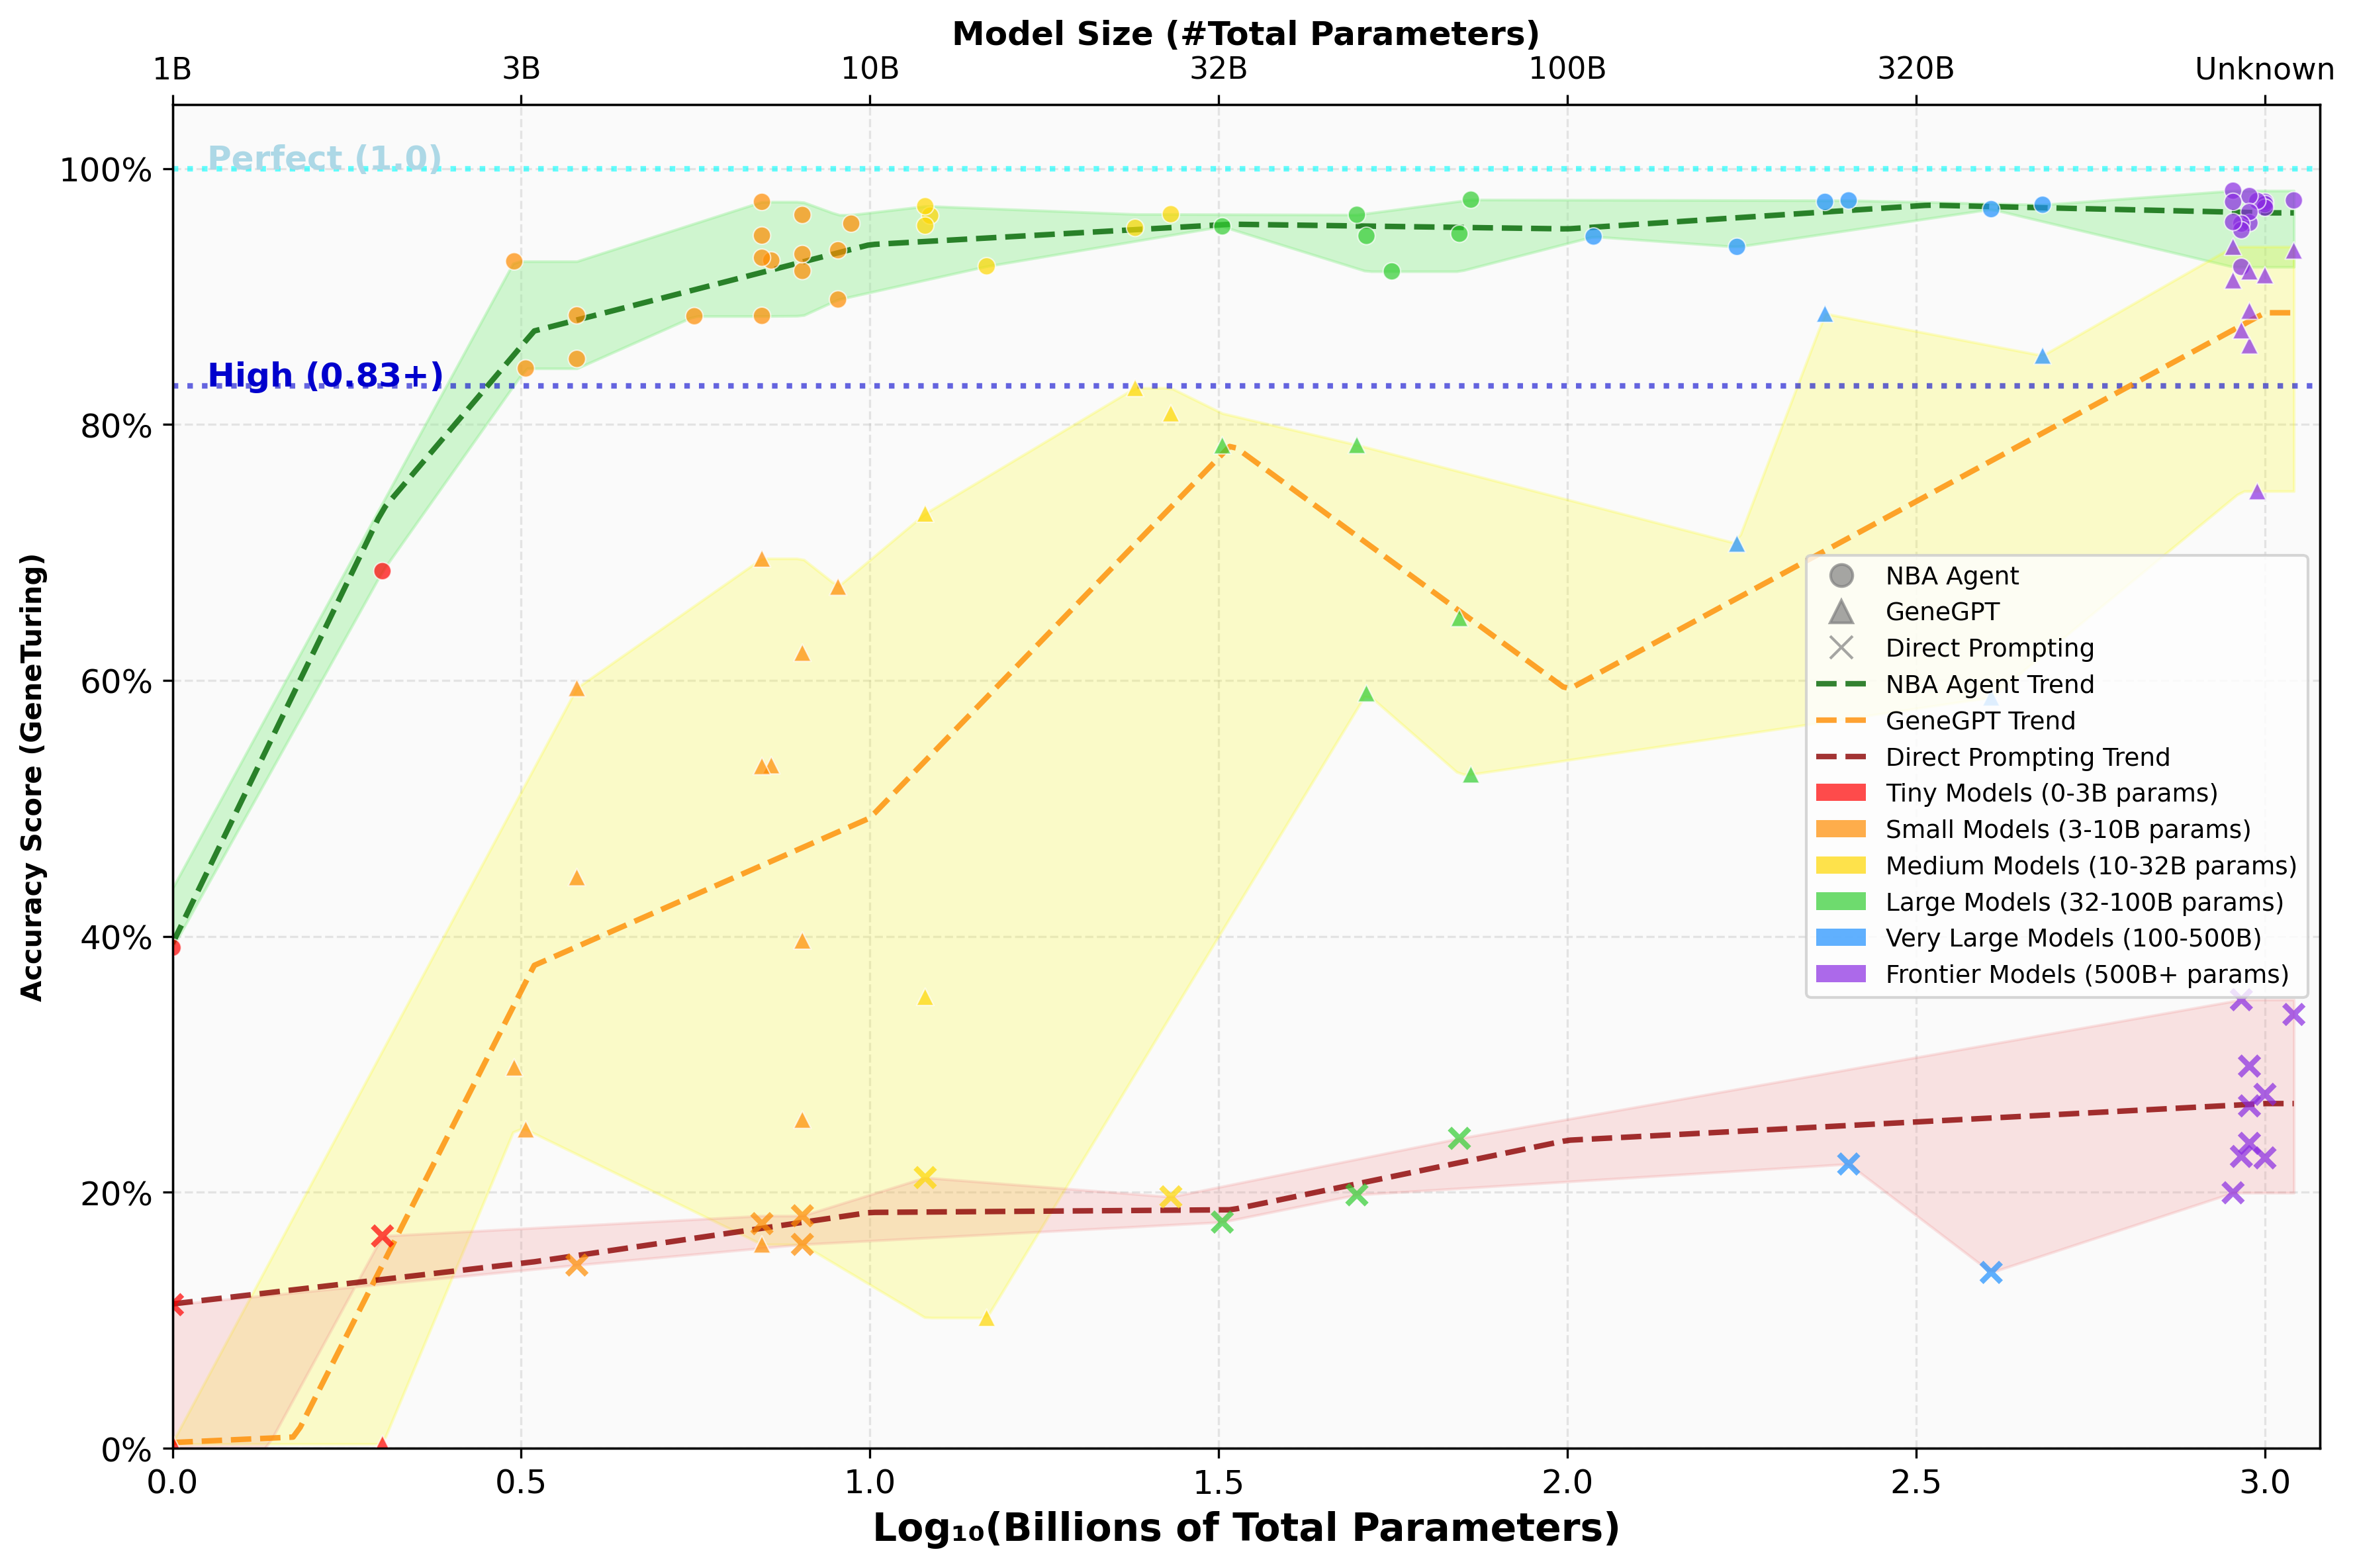

In [5]:
''' Figure multi ==> method_comprison '''

breakpoints_llm_1 = [1000e9, 330e9, 100e9, 33e9, 10e9, 3.3e9, 2e9, 1e9]
breakpoints_log_1 = [np.log10(bp)-9 for bp in breakpoints_llm_1]

breakpoints_llm_2 = [1000e9, 100e9, 33e9, 10e9, 3.3e9, 15e8, 1e9]
breakpoints_log_2 = [np.log10(bp)-9 for bp in breakpoints_llm_2]

breakpoints_llm_3 = [1000e9, 100e9, 33e9, 10e9, 3.3e9, 1e9]
breakpoints_log_3 = [np.log10(bp)-9 for bp in breakpoints_llm_3]

# Call the multi-dataset function
fig, ax = plot_nba_performance_multi(
    list_data_file=['data_nba_agent_v3.csv', 'data_nba_genegpt_v3.csv', 'data_nba_direct_v3.csv'],
    figsize=(12, 8),
    list_breakpoints=[breakpoints_log_1, breakpoints_log_2, breakpoints_log_3],
    window_size=0.1,
    plot_label='',
    list_markers=['o', '^', 'x'],  # circle, square, triangle ['o', 's', '^']
    list_labels=['NBA Agent', 'GeneGPT', 'Direct Prompting'],
    legend_loc='center right'
)

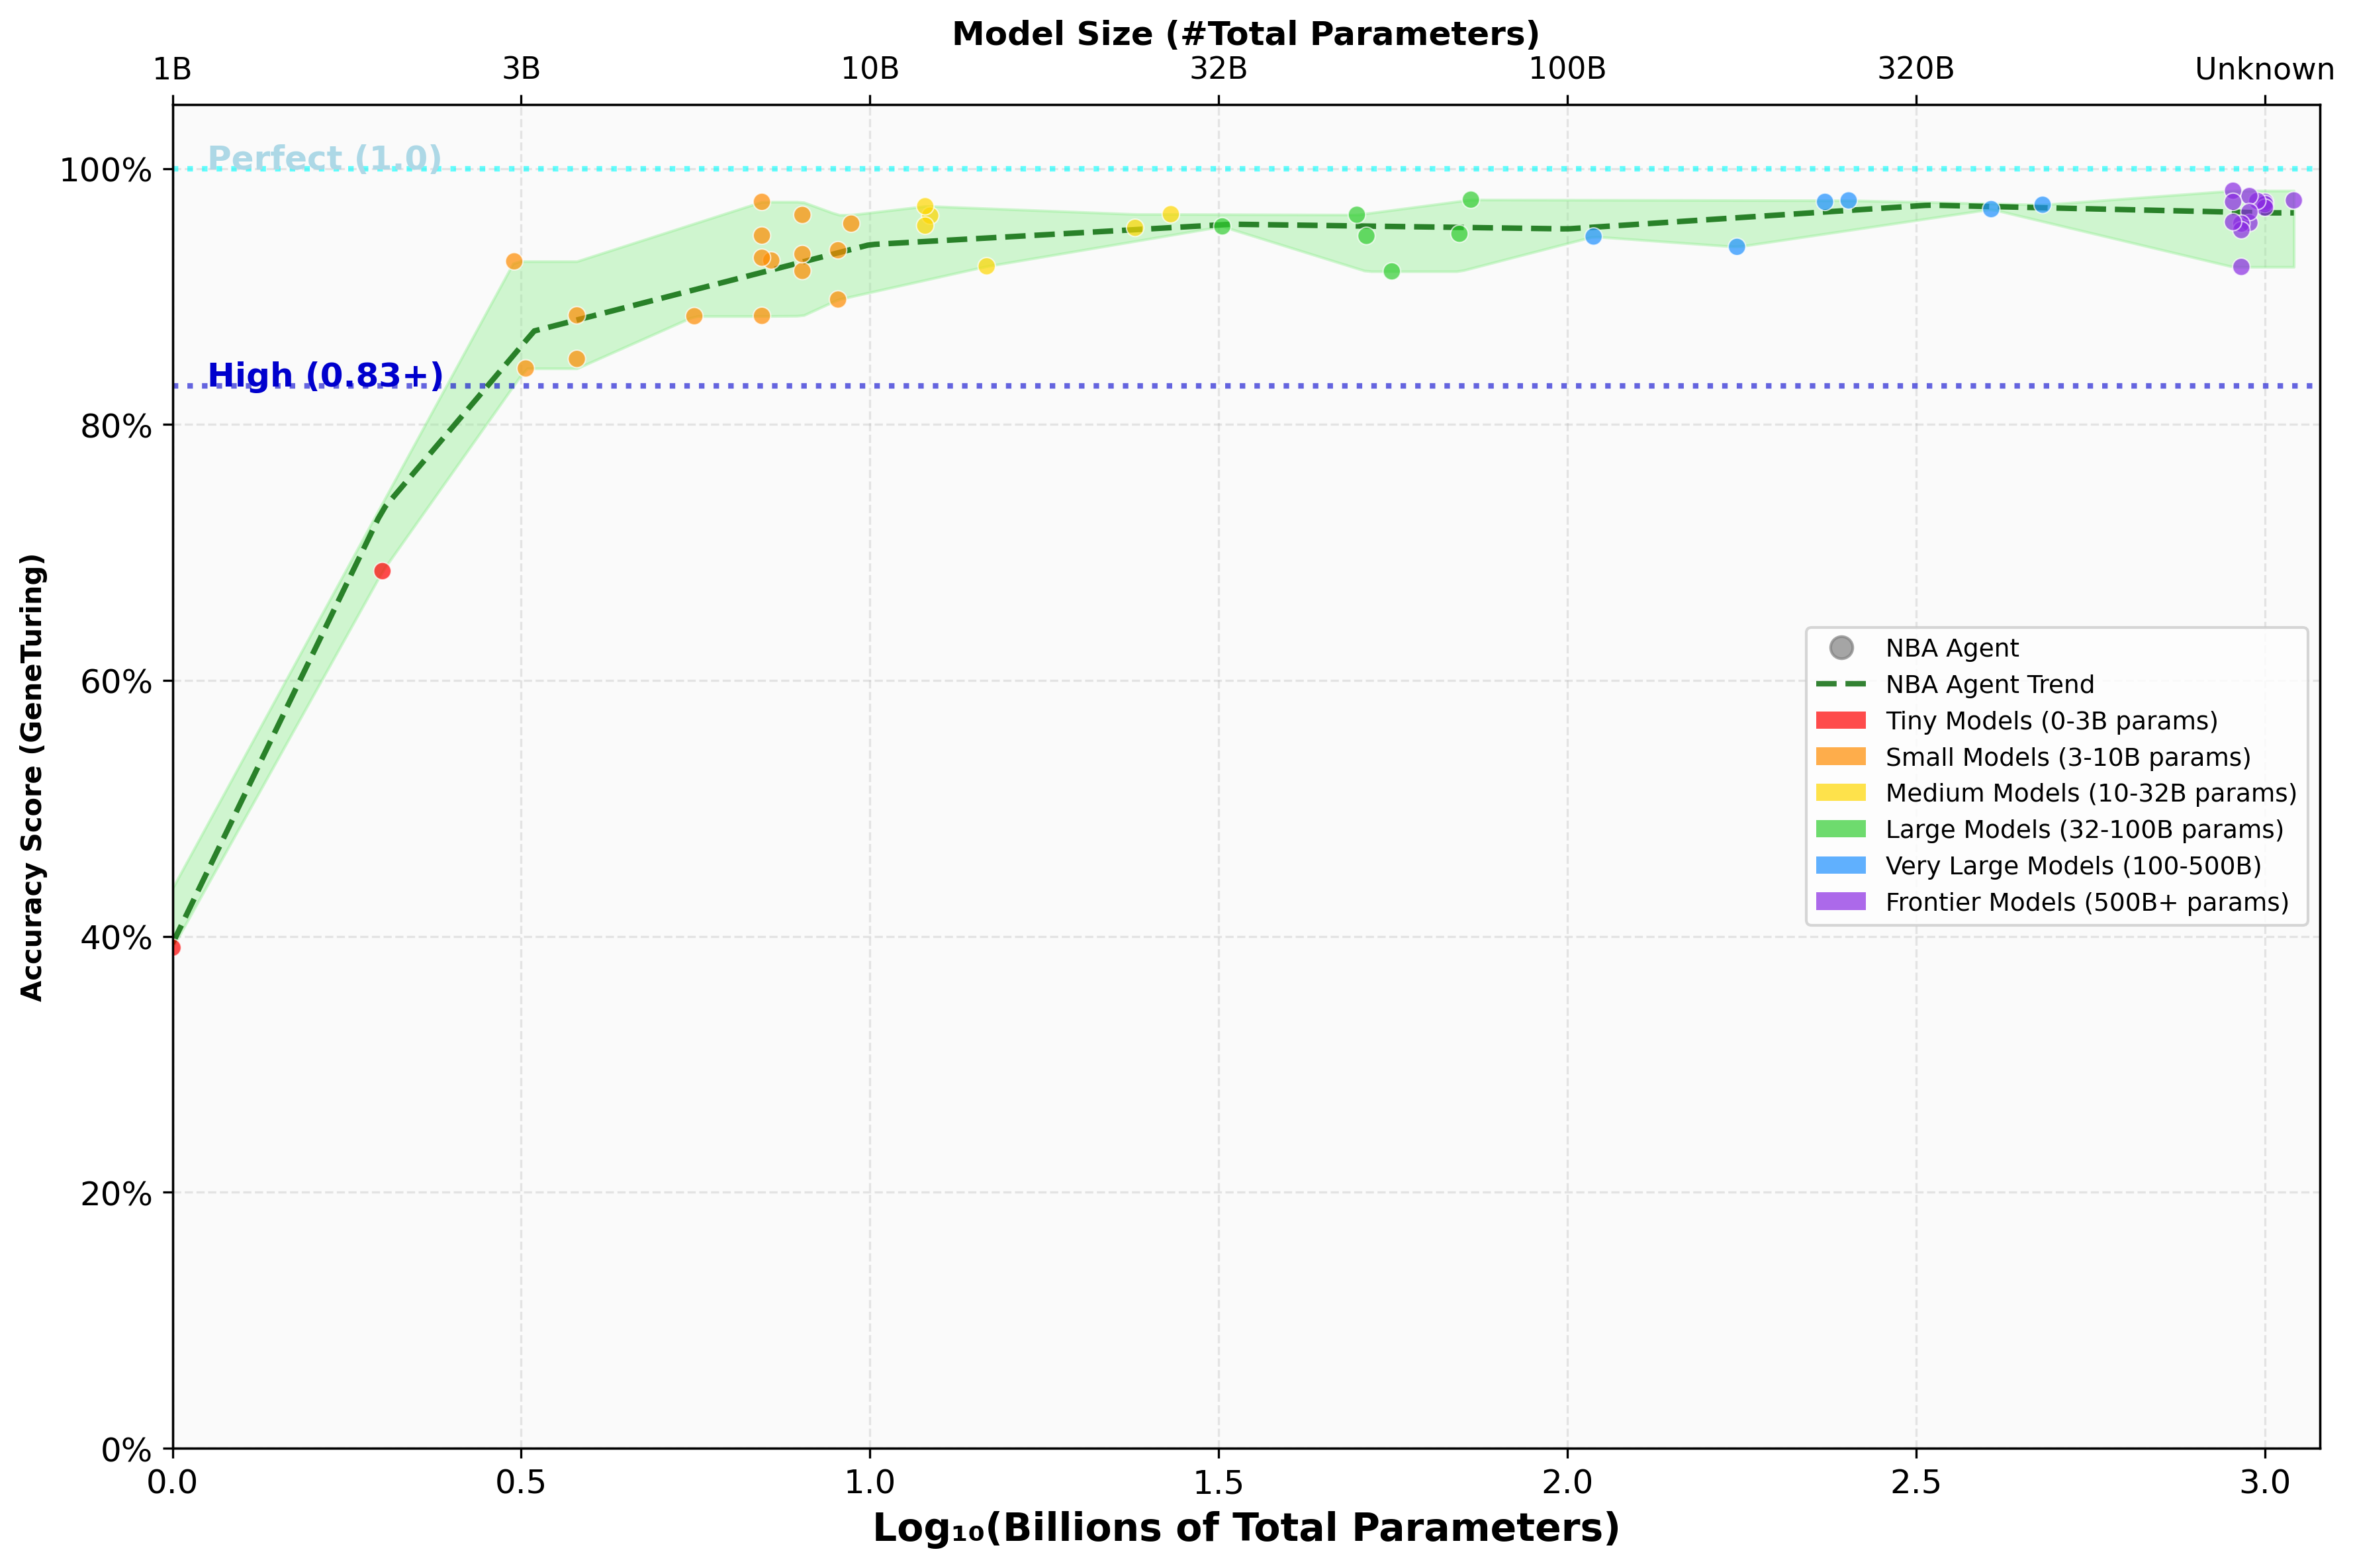

In [6]:
fig, ax = plot_nba_performance_multi(
    list_data_file=['data_nba_agent_v3.csv'],
    figsize=(12, 8),
    list_breakpoints=[breakpoints_log_1],
    window_size=0.1,
    plot_label='',
    list_markers=['o'],  # circle, square, triangle ['o', 's', '^']
    list_labels=['NBA Agent'],
    legend_loc='center right'
)

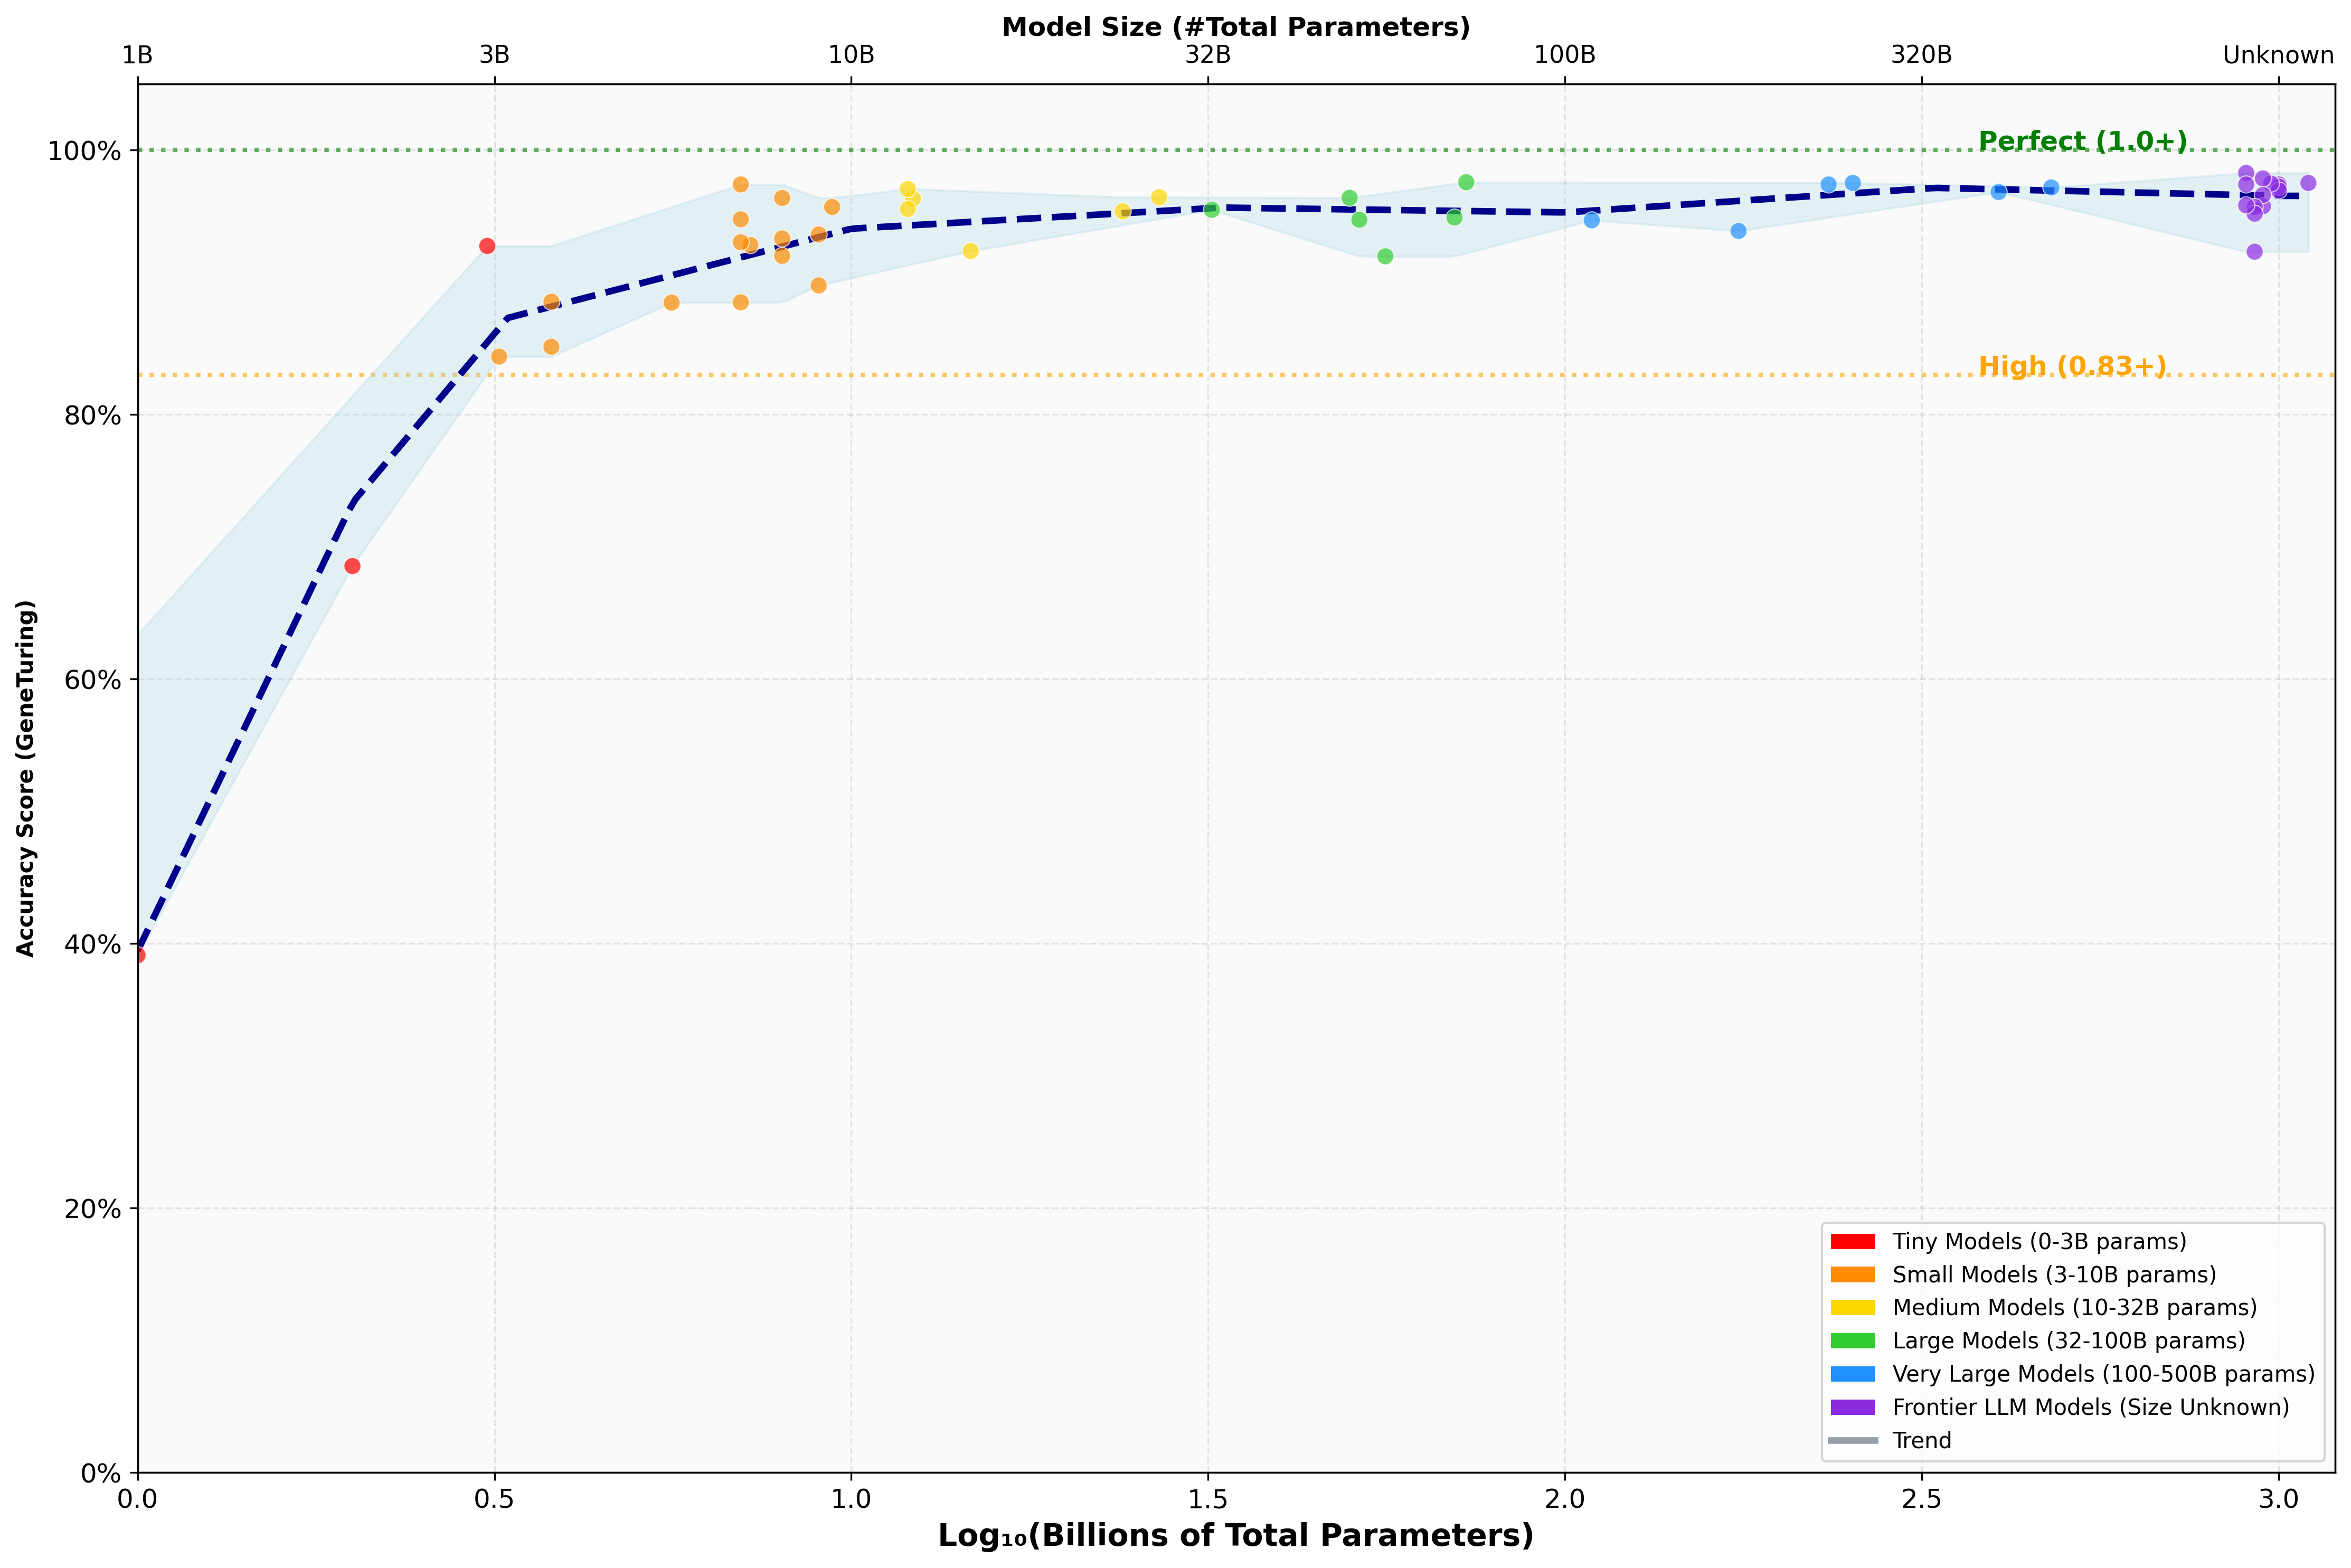

In [7]:
''' Figure single ==> method_agent '''
figsize=(15, 10)
# Define breakpoints in absolute numbers and convert to log
breakpoints_llm = [1000e9, 330e9, 100e9, 33e9, 10e9, 3.3e9, 2e9, 1e9]
breakpoints_log = [np.log10(bp)-9 for bp in breakpoints_llm]
# fig, ax = plot_nba_performance('data_nba_agent_v1.csv', output_file='data_nba_agent_v1.png',
#                   trend_type='kernel_piecewise', breakpoints=breakpoints_log,
#                   envelope_type='direct', window_size=0.08)

plot_label = '' # 'Performance Across Model Sizes (Agent)'
fig, ax = plot_nba_performance('data_nba_agent_v3.csv', figsize=figsize, breakpoints=breakpoints_log, 
                            window_size=0.1, plot_label=plot_label)


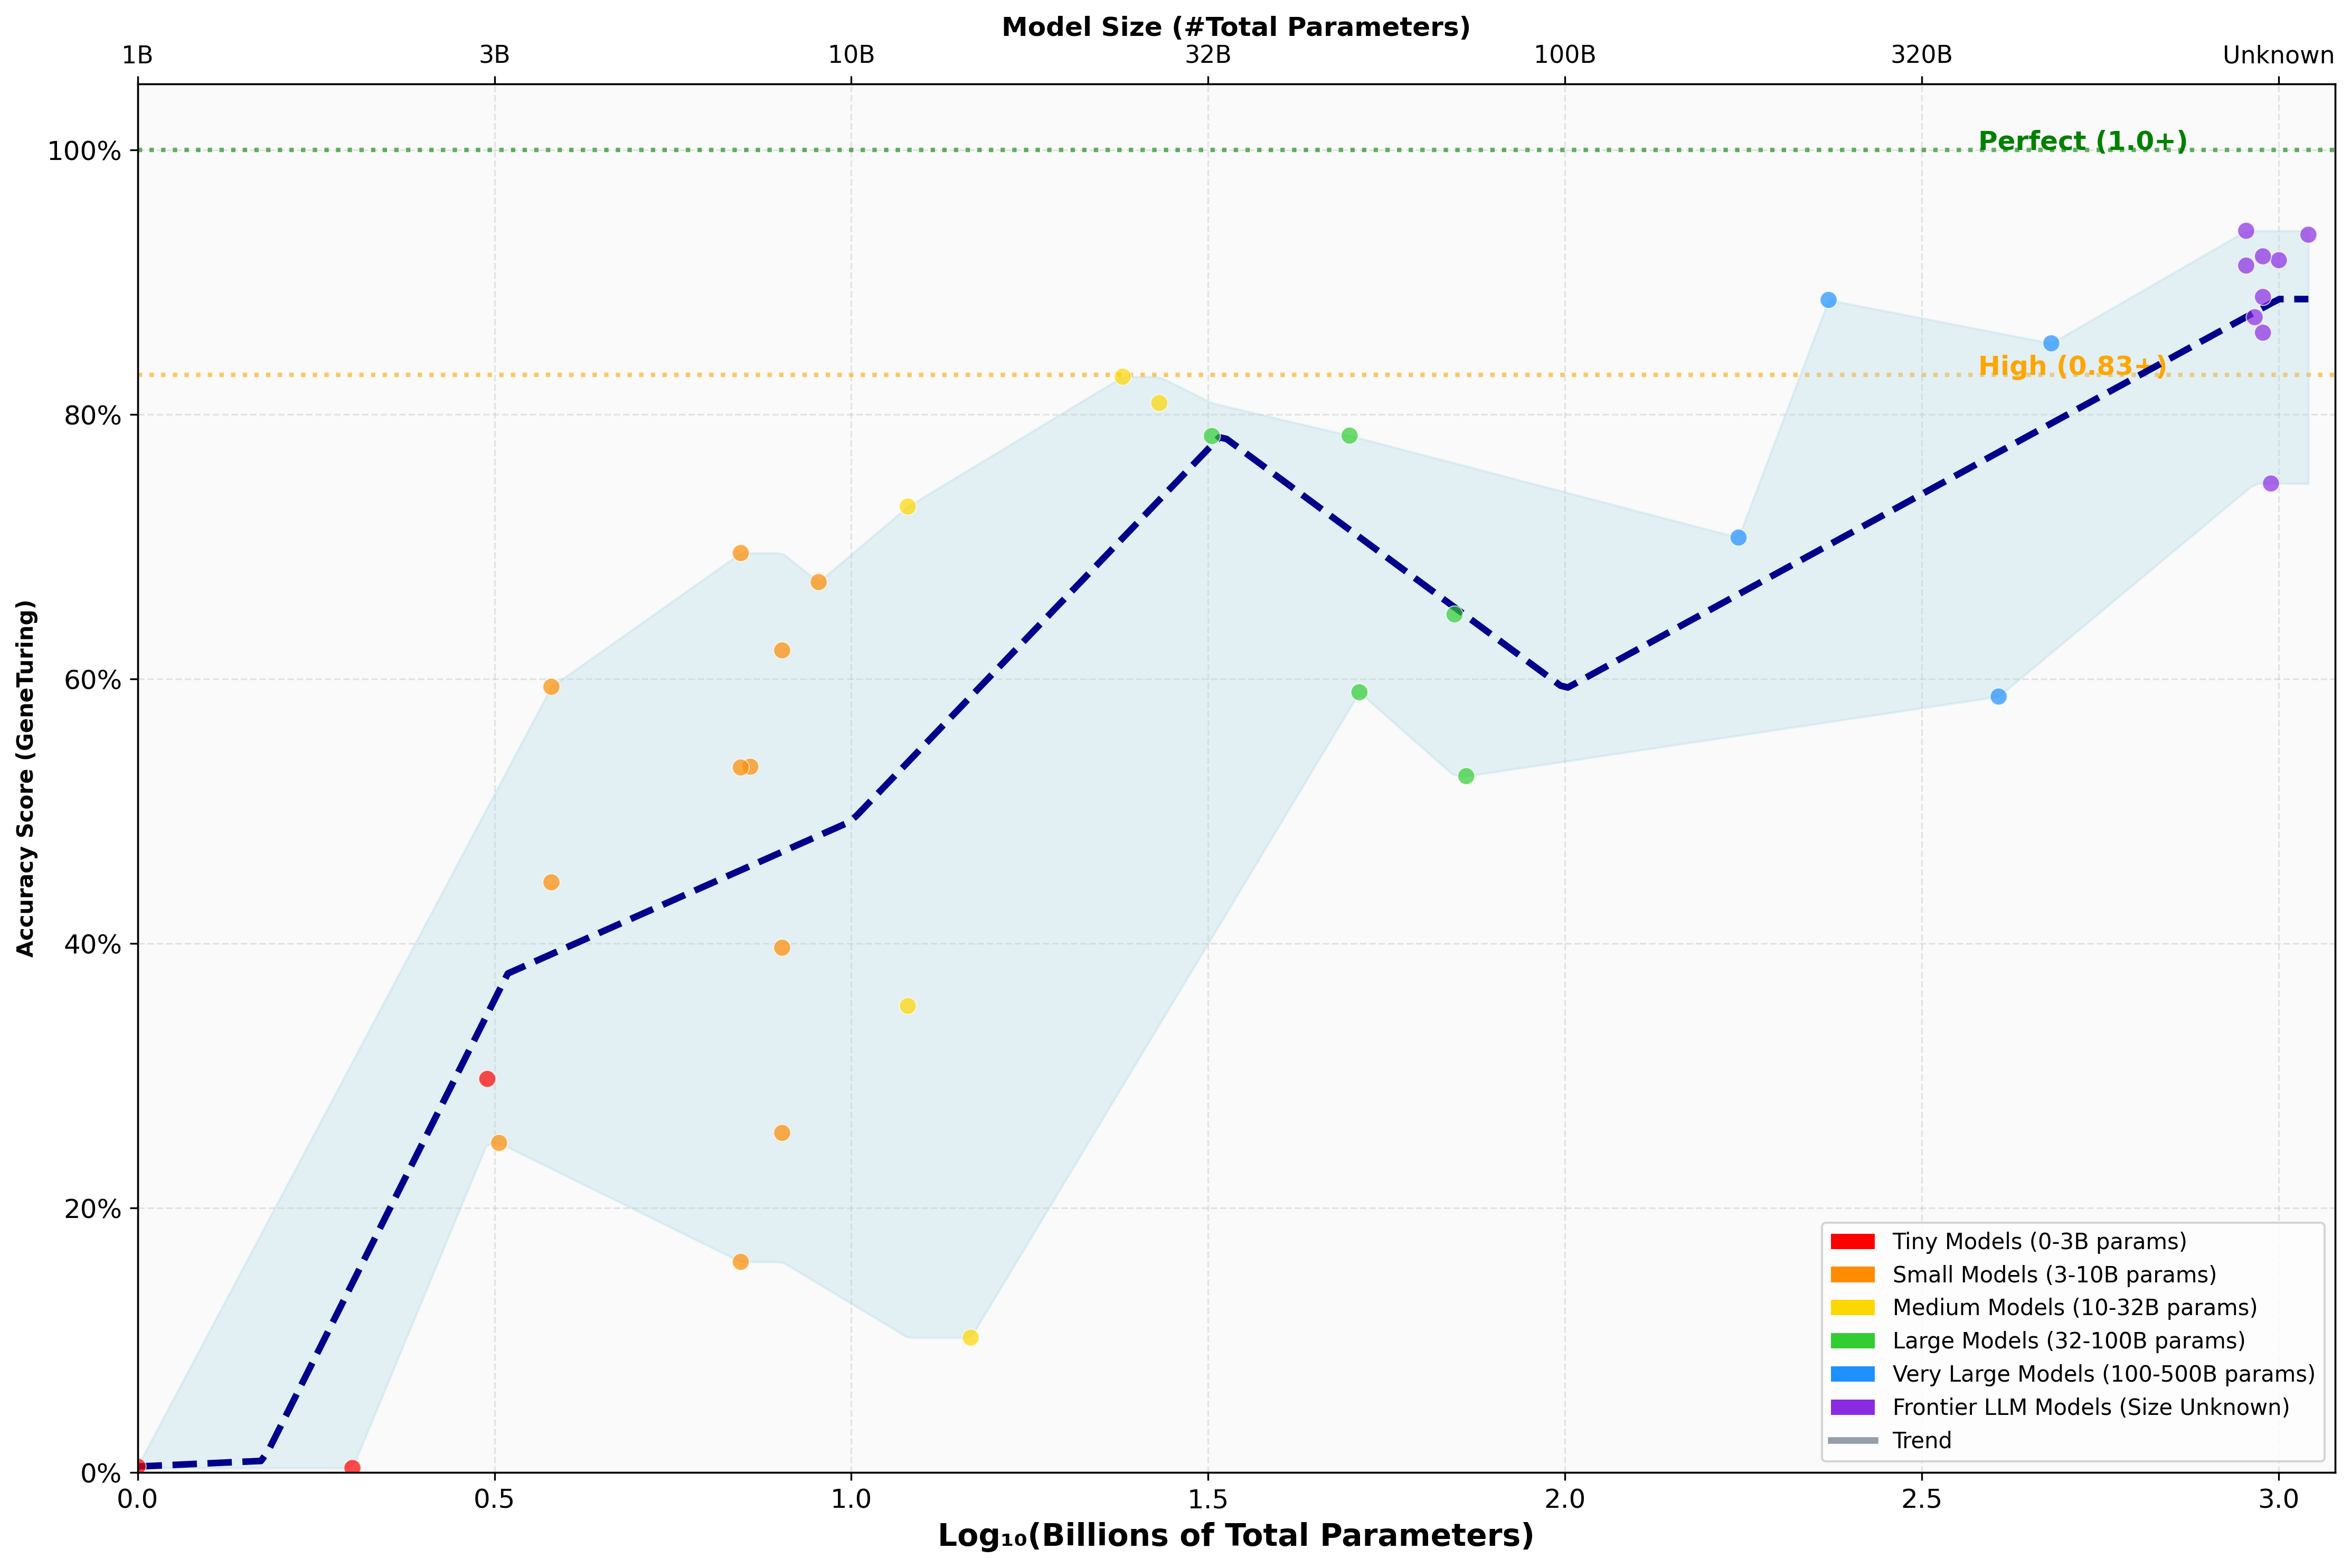

In [8]:
''' Figure single ==> method_genegpt '''
# figsize=(7.5, 5)
breakpoints_llm = [1000e9, 100e9, 33e9, 10e9, 3.3e9, 15e8, 1e9]
breakpoints_log = [np.log10(bp)-9 for bp in breakpoints_llm]
plot_label = '' # 'Performance Across Model Sizes (GeneGPT)'
fig, ax = plot_nba_performance('data_nba_genegpt_v3.csv', figsize=figsize,
                            breakpoints=breakpoints_log, window_size=0.1, plot_label=plot_label)

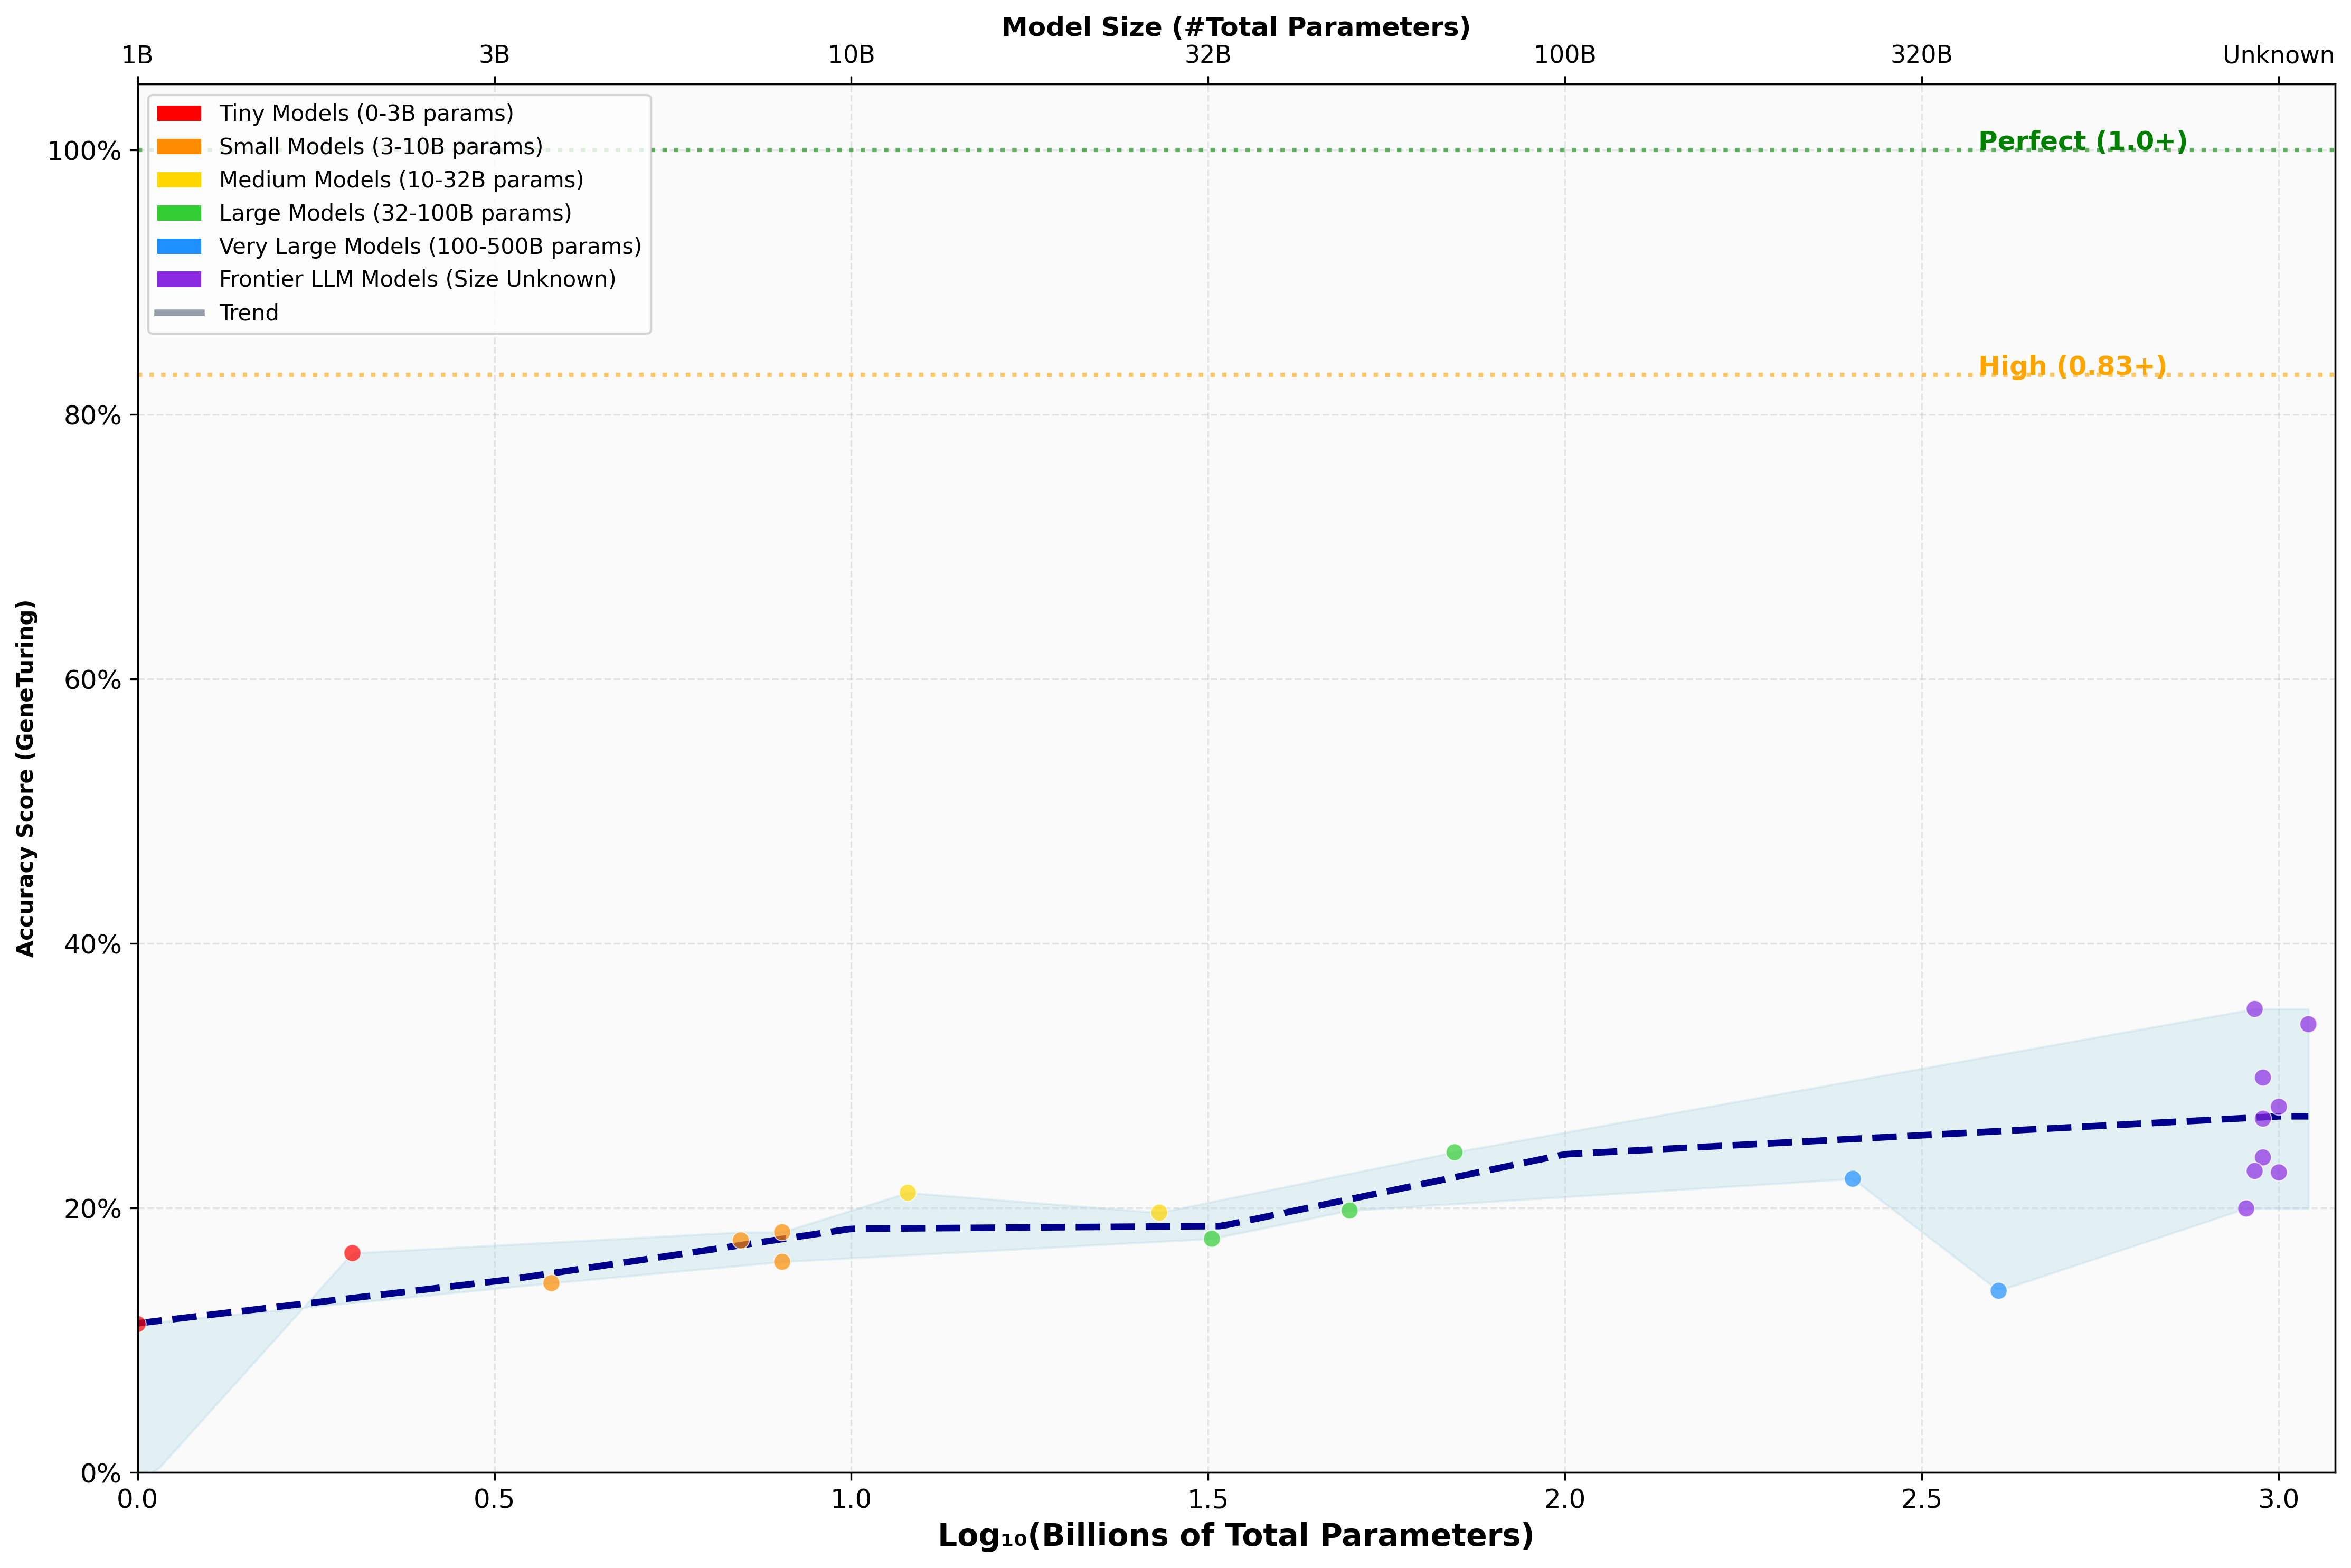

In [9]:
''' Figure single ==> direct prompting '''
breakpoints_llm = [1000e9, 100e9, 33e9, 10e9, 3.3e9, 1e9]
breakpoints_log = [np.log10(bp)-9 for bp in breakpoints_llm]
plot_label = '' # 'Performance Across Model Sizes (Direct Promping)'
fig, ax = plot_nba_performance('data_nba_direct_v3.csv', figsize=figsize,
                            breakpoints=breakpoints_log, window_size=0.1, plot_label=plot_label, legend_loc ='upper left')

In [10]:
''' Figure horizontal ==> data_scores_per_questions_xxx '''
def plot_nba_scores_per_question_horizontal(data_file, output_file=None, figsize=(12, 16), dpi=300, plot_label=''):
    
    df = pd.read_csv(data_file)
    if output_file is None:
        import os
        base_name = os.path.splitext(data_file)[0]  # Remove .csv extension
        output_file = f"{base_name}_horizontal.png"
        
    # Clean column names (remove spaces for easier access)
    df.columns = df.columns.str.strip()

    # Extract the scores - convert percentage strings to floats if needed
    if df['score agent'].dtype == 'object':  # If stored as strings like "100.00%"
        df['score agent'] = df['score agent'].str.rstrip('%').astype(float) / 100
        df['score genegpt'] = df['score genegpt'].str.rstrip('%').astype(float) / 100

    genegpt_scores = df['score genegpt'].values
    agent_scores = df['score agent'].values
    
    # Create horizontal plot
    fig, ax = plt.subplots(figsize=figsize)

    # Get unique questions and models
    questions = df['question'].unique()
    models = df['model'].unique()

    # Calculate for each question: % of models where agent wins/ties/loses
    question_stats = []

    for q_idx, question in enumerate(questions):
        question_df = df[df['question'] == question]
        
        # Calculate differences for this question across all models
        diffs = question_df['score agent'] - question_df['score genegpt']
        
        total_models = len(diffs)
        agent_better = (diffs > 0.01).sum()
        ties = (np.abs(diffs) <= 0.01).sum()
        genegpt_better = (diffs < -0.01).sum()
        
        # Calculate percentages
        agent_better_pct = (agent_better / total_models) * 100 if total_models > 0 else 0
        tie_pct = (ties / total_models) * 100 if total_models > 0 else 0
        genegpt_better_pct = (genegpt_better / total_models) * 100 if total_models > 0 else 0
        
        max_char = 50
        question_stats.append({
            'question_idx': q_idx,
            'question': question,
            'question_short': question[:max_char] + '...' if len(question) > max_char else question,
            'agent_better_pct': agent_better_pct,
            'tie_pct': tie_pct,
            'genegpt_better_pct': genegpt_better_pct,
            'mean_diff': diffs.mean(),
            'n_models': total_models
        })

    question_stats_df = pd.DataFrame(question_stats)

    # Sort by agent_better_pct (descending), then by genegpt_better_pct (ascending)
    question_stats_df = question_stats_df.sort_values(
        by=['agent_better_pct', 'genegpt_better_pct'], 
        ascending=[False, True]
    )
    question_stats_df = question_stats_df.reset_index(drop=True)

    # Create horizontal stacked bar chart with gaps
    y = np.arange(len(question_stats_df))
    height = 0.7  # Create gaps between bars (less than 1.0)

    # Pastel/subtle colors
    agent_color = '#90CDB0'  # Soft sage green
    tie_color = '#B8E6B8'    # Light mint green  
    genegpt_color = '#F4A4A4'  # Soft coral red

    # Plot horizontal stacked bars
    bars1 = ax.barh(y, question_stats_df['agent_better_pct'], height, 
                    label='Agent > GeneGPT (Strictly Outperforms)', color=agent_color, edgecolor='none', alpha=0.9)
    bars2 = ax.barh(y, question_stats_df['tie_pct'], height, 
                    left=question_stats_df['agent_better_pct'],
                    label='Agent = GeneGPT (Tie)', color=tie_color, edgecolor='none', alpha=0.9)
    bars3 = ax.barh(y, question_stats_df['genegpt_better_pct'], height,
                    left=question_stats_df['agent_better_pct'] + question_stats_df['tie_pct'],
                    label='Agent < GeneGPT (Strictly Underperforms)', color=genegpt_color, edgecolor='none', alpha=0.9)

    if plot_label == '':
        plot_label = f'Agent vs GeneGPT: Performance Across {len(questions)} Questions\n(Top: Agent dominates → Bottom: GeneGPT competitive)'
    
    # Styling
    ax.set_xlabel('Percentage of Models by Performance', fontsize=13, fontweight='bold')
    ax.set_ylabel('Questions (sorted by Agent outperform rate)', fontsize=13, fontweight='bold')
    ax.set_title(plot_label, fontsize=15, fontweight='bold', pad=20, loc='left')
    ax.set_ylim(-0.5, len(y)-0.5)
    ax.set_xlim(0, 100)

    # Legend positioning (move to upper right for horizontal layout)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.95)

    # Grid with subtle styling (vertical for horizontal bars)
    ax.grid(True, alpha=0.2, axis='x', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Add subtle reference lines
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(x=100, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)

    # Custom y-axis labels - show question text every 10th question
    y_labels = []
    y_positions = []
    every_n_questions = 10
    for i in range(len(question_stats_df)):
        if i % every_n_questions == 0 or i == len(question_stats_df) - 1:  # Every n-th + last question
            # y_labels.append(f"Q{i+1}: {question_stats_df.iloc[i]['question_short']}")
            y_labels.append(f"Q: {question_stats_df.iloc[i]['question_short']}")
            y_positions.append(i)
    
    # Set custom y-tick positions and labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontsize=7)
    
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Invert y-axis so highest performing questions are at top
    ax.invert_yaxis()

    # Add minor ticks for the questions without labels
    ax.set_yticks(range(len(question_stats_df)), minor=True)
    # ax.tick_params(which='minor', left=True, right=False, length=3, width=0.5)
    ax.tick_params(which='minor', left=True, right=False, length=3, width=0.5, color='gray')
    plt.tight_layout()

    # Save if requested
    if output_file:
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight', facecolor='white', edgecolor='none')
        print(f"Plot saved to: {output_file}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Total Questions: {len(question_stats_df)}")
    print(f"Questions where Agent outperforms majority (>50% models): {(question_stats_df['agent_better_pct'] > 50).sum()}")
    print(f"Questions where GeneGPT outperforms majority: {(question_stats_df['genegpt_better_pct'] > 50).sum()}")
    print(f"Questions with mostly ties: {(question_stats_df['tie_pct'] > 50).sum()}")
    
    return fig, ax

Plot saved to: data_scores_per_questions_v3_horizontal.png


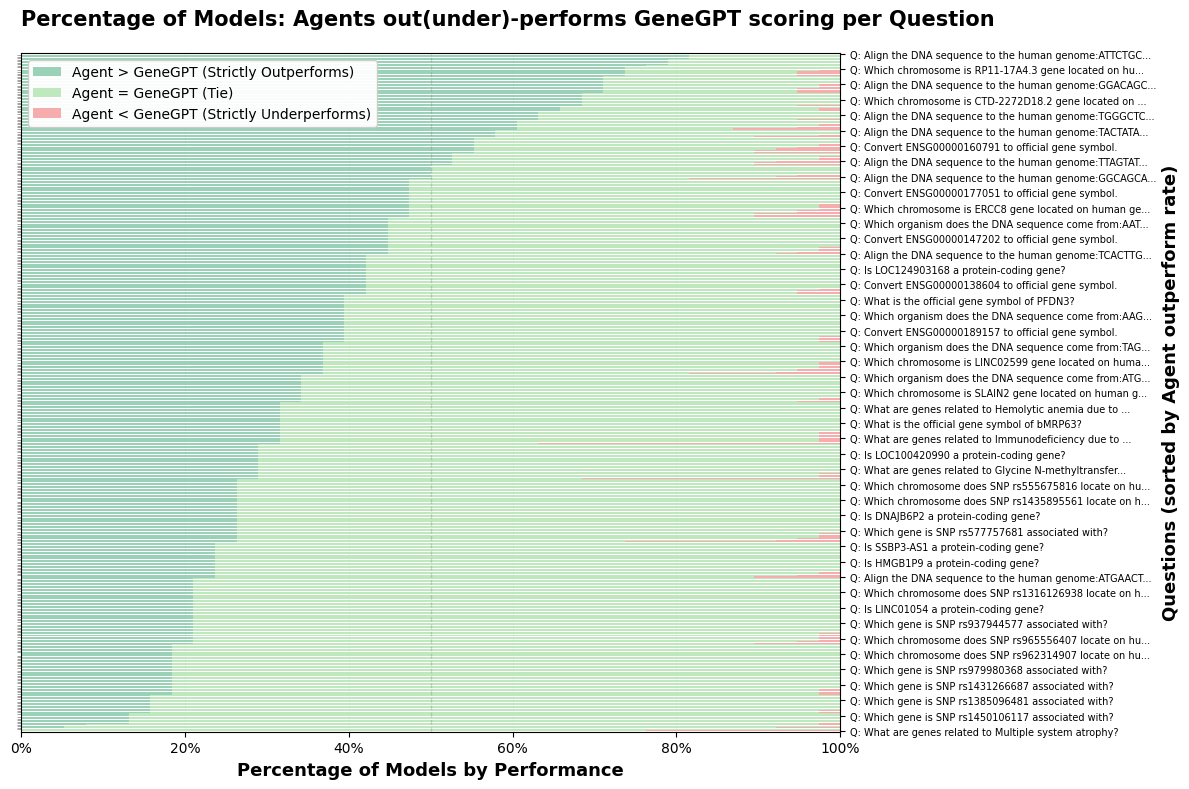


Summary Statistics:
Total Questions: 441
Questions where Agent outperforms majority (>50% models): 73
Questions where GeneGPT outperforms majority: 0
Questions with mostly ties: 344


In [11]:
figsize=(12, 8)
plot_label = 'Percentage of Models: Agents out(under)-performs GeneGPT scoring per Question'
fig, ax = plot_nba_scores_per_question_horizontal('data_scores_per_questions_v3.csv', figsize=figsize, plot_label=plot_label)

In [12]:
def plot_nba_scores_heatmap_by_task(data_file, output_file=None, figsize=(14, 8), dpi=300, plot_label='Model Performance Heatmap by Task', 
                                    score_col='score agent'):
    df = pd.read_csv(data_file)

    if output_file is None:
        import os
        base_name = os.path.splitext(data_file)[0]  # Remove .csv extension
        output_file = f"{base_name}.png"
        
    # Convert score agent to numeric (remove % and divide by 100)
    # Check if score column contains strings with % or is already numeric
    if df[score_col].dtype == 'object':
        # Convert score to numeric (remove % and divide by 100)
        df['score_numeric'] = pd.to_numeric(df[score_col].str.replace('%', '')) / 100
    else:
        # Score is already numeric
        df['score_numeric'] = df[score_col]

    # Group by task and model to get average scores
    task_model_scores = df.groupby(['task', 'model'])['score_numeric'].mean().reset_index()

    # Get average score per task across all models for sorting
    task_avg_scores = df.groupby('task')['score_numeric'].mean().sort_values(ascending=False)

    # Get unique models with their parameter counts for sorting
    model_params = df[['model', 'num_parameters']].drop_duplicates()
    model_params = model_params.sort_values('num_parameters')

    # Create pivot table for heatmap
    heatmap_data = task_model_scores.pivot(index='task', columns='model', values='score_numeric')

    # Reorder rows (tasks) by average performance (best to worst)
    heatmap_data = heatmap_data.reindex(task_avg_scores.index)

    # Reorder columns (models) by parameter size (small to large)
    heatmap_data = heatmap_data.reindex(columns=model_params['model'])

    # Create the heatmap
    plt.figure(figsize=figsize)

    # Create custom colormap: red for low scores, green for high scores
    cmap = sns.diverging_palette(10, 120, s=80, l=55, as_cmap=True)

    # Create heatmap
    ax = sns.heatmap(heatmap_data, 
                    annot=True,           
                    fmt='.2f',            
                    cmap=cmap,            
                    center=0.5,           
                    square=False,          # Allow rectangular cells
                    linewidths=0.1,       # Thinner grid lines
                    annot_kws={'size': 6}, # Smaller annotation text
                    cbar_kws={'label': 'Average Score'})

    # Customize the plot
    plt.title(plot_label, fontsize=14, pad=20)
    plt.xlabel('Models (Approximately placed as: small → large)', fontsize=12)
    ax.yaxis.set_label_position('right')
    # ax.yaxis.tick_right()
    plt.ylabel('Tasks (ordered by average performance: low → high)', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, va='top')

    # Add parameter count annotations below model names
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Define the specific parameter thresholds you want to show
    param_thresholds = [1e9, 3e9, 12e9, 33e9, 100e9, 1000e9]  # 1B, 3B, 10B, 33B, 100B
    param_labels_clean = ['1B', '3B', '10B', '33B', '100B', '<--- Unknown']

    # Find positions where to place these labels (avoid duplicates)
    tick_positions = []
    tick_labels = []
    used_labels = set()  # Track which labels we've already used

    for i, model in enumerate(heatmap_data.columns):
        matching_params = model_params[model_params['model'] == model]['num_parameters']
        if len(matching_params) > 0:
            param_count = matching_params.iloc[0]
            
            # Check if this model's parameter count matches any of our thresholds
            for threshold, label in zip(param_thresholds, param_labels_clean):
                if abs(param_count - threshold) / threshold < 0.1 and label not in used_labels:
                    tick_positions.append(i + 0.5)  # Center of the cell
                    tick_labels.append(label)
                    used_labels.add(label)  # Mark this label as used
                    break

    # Add "Unknown" at the rightmost position
    all_positions = tick_positions + [len(heatmap_data.columns) - 0.25]
    all_labels = tick_labels + ['(Unavailable) --->']

    # Set the ticks and labels
    ax2.set_xticks(all_positions)
    ax2.set_xticklabels(all_labels, fontsize=10, color='gray')
    ax2.set_xlabel('Parameter Count (Open models only. Unavailable param size for some models)', fontsize=10, color='gray')

    # Custom box styling around y-axis labels
    for tick in ax.get_xticklabels():
        tick.set_bbox(dict(
            boxstyle="round,pad=0.4",    # Rounded corners with padding
            facecolor="lightblue",           # Background color
            edgecolor="white",           # Border color
            linewidth=0.1,                 # Border width
            alpha=0.2                    # Transparency
        ))
    
    # Different box styles
    for tick in ax.get_yticklabels():
        tick.set_bbox(dict(
            boxstyle="square,pad=0.3",   # Square boxes
            # or boxstyle="sawtooth,pad=0.3"  # Sawtooth edges
            # or boxstyle="round4,pad=0.3"    # Very rounded corners
            facecolor="lightblue",
            edgecolor="gray",
            linewidth=0.5,
            alpha=0.8                    # Transparency
        ))
    
    plt.tight_layout()
    try:
        print(f"Trying to save to: {output_file}")
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight', facecolor='white', edgecolor='none')
        print(f"Successfully saved to: {output_file}")
    except Exception as e:
        print(f"Error saving file: {e}")

    plt.show()

    # Print summary statistics
    print("Task Performance Summary (sorted by average score):")
    print("-" * 50)
    for task, avg_score in task_avg_scores.items():
        print(f"{task:<35}: {avg_score:.3f}")

    print(f"\nModel Parameter Summary (sorted by size):")
    print("-" * 50)
    for _, row in model_params.iterrows():
        param_str = f"{row['num_parameters']:,}" if row['num_parameters'] < 1e9 else f"{row['num_parameters']/1e9:.1f}B"
        print(f"{row['model']:<35}: {param_str}")
        
    return fig, ax


Trying to save to: data_nba_agent_by_task_v3.png
Successfully saved to: data_nba_agent_by_task_v3.png


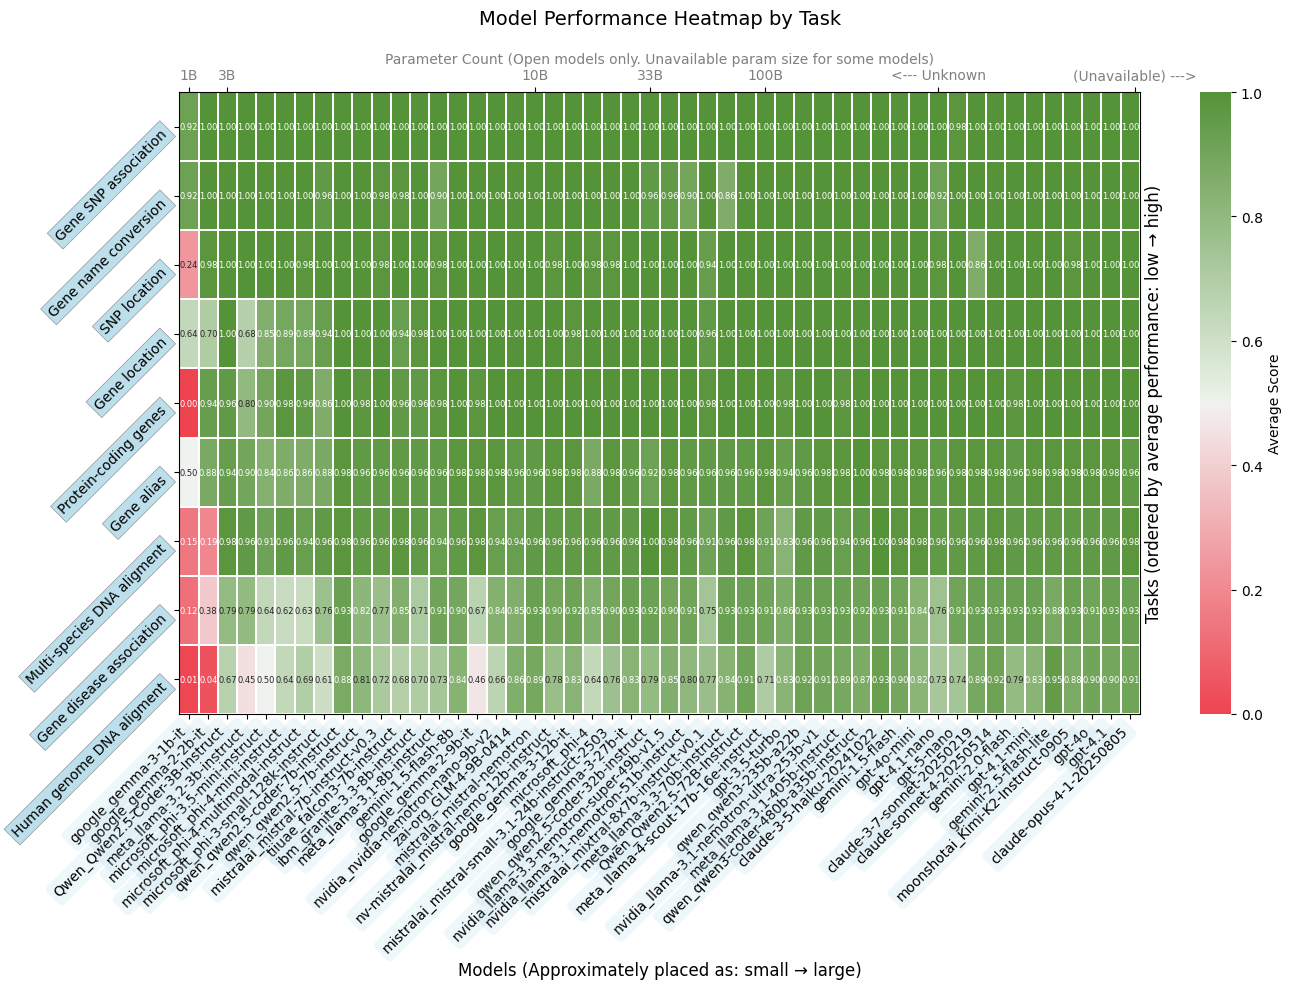

Task Performance Summary (sorted by average score):
--------------------------------------------------
Gene SNP association               : 0.998
Gene name conversion               : 0.987
SNP location                       : 0.977
Gene location                      : 0.969
Protein-coding genes               : 0.964
Gene alias                         : 0.946
Multi-species DNA aligment         : 0.925
Gene disease association           : 0.837
Human genome DNA aligment          : 0.757

Model Parameter Summary (sorted by size):
--------------------------------------------------
google_gemma-3-1b-it               : 1.0B
google_gemma-2-2b-it               : 2.0B
Qwen_Qwen2.5-Coder-3B-Instruct     : 3.1B
meta_llama-3.2-3b-instruct         : 3.2B
microsoft_phi-3.5-mini-instruct    : 3.8B
microsoft_phi-4-mini-instruct      : 3.8B
microsoft_phi-4-multimodal-instruct: 5.6B
microsoft_phi-3-small-128k-instruct: 7.0B
qwen_qwen2.5-coder-7b-instruct     : 7.0B
qwen_qwen2.5-7b-instruct           : 7

In [13]:
figsize=(14, 10)
plot_label = 'Percentage of Models where Agents out(under)-performs GeneGPT per Question'
fig, ax = plot_nba_scores_heatmap_by_task('data_nba_agent_by_task_v3.csv', output_file=None, figsize=figsize, score_col='score')